## Import dependencies

In [963]:
import requests
from bs4 import BeautifulSoup
from operator import itemgetter
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm


import networkx as nx
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


pd.options.display.max_colwidth = 30

## Web-scraping and creating a dataframe

In [561]:
urls = []
url = 'https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_characteranimation.htm'
urls.append(url)

response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

## getting all the topic name with url
text_options = soup.find_all('p', class_='TextOption')[1]

links = text_options.find_all('a')

for i in links:
    new_Url = "https://sitescrape.awh.durham.ac.uk/comp42315/"+ i['href']
    urls.append(new_Url)
#     print(new_Url)

topic_names = ['Character Animation','Motion Analysis','Interaction Modelling','Biomedical Engineering','3D Reconstruction','Action Recognition','Surface Modelling','Crowd Modelling','Face Modelling','Virtual Reality','Robotics','Biometrics','Hand and Gesture','Computational Intelligence']

# Create an empty dataframe
df = pd.DataFrame(columns=["Topic", "Publication URL", "Title", "Citation", "Impact_factor","LDO_Name","LDO_Num","Auther", "Vanue", "Year"])

# Scraping code ...
for j, paper_url in enumerate(urls):
  response = requests.get(paper_url)
  soup = BeautifulSoup(response.content, 'html.parser')
  publications = soup.select('a[class="LinkButton"]')
  topic = topic_names[j]

  # Loop through each link in 'links'
  for link in publications:
      publication_url = "https://sitescrape.awh.durham.ac.uk/comp42315/" + link['href']
#       print(publication_url)
      
      # Append a new row to the dataframe for each topic-publication pair
      temp_df = pd.DataFrame({'Topic': [topic], 'Publication URL': [publication_url]})
      temp_df = temp_df.drop_duplicates()
      df = pd.concat([df, temp_df], ignore_index=True)
      

data = []
for index, row in df.iterrows(): 
    xurl = row["Publication URL"]
    page = requests.get(xurl)
    soup_Pages = BeautifulSoup(page.content,"html.parser")  
    
    #------------------------------------------------------------------------------#
    ## title of the paper:
    titles = soup_Pages.select("h1")
    title_name = titles[0].text

    #------------------------------------------------------------------------------#  

    #Citation:
    start = str(soup_Pages).find("Citation:")
    end = str(soup_Pages).find("##", start)
    citation_number = str(soup_Pages)[start+9:end].strip().split('<')[0]
    try:
        citation_number = int(citation_number)
    except ValueError:
        citation_number = 0

    #------------------------------------------------------------------------------#
    #Impact_factor
    start_im = str(soup_Pages).find("Impact Factor:")
    impact__string = str(soup_Pages)[start_im+15:].strip().split('<')[0].strip()
    try:
        impact_number = float(impact__string)
    except ValueError:
        impact_number = 0
    
    #------------------------------------------------------------------------------#
     #LDO:
    ldo = soup_Pages.find_all("div", style="margin-left: var(--size-marginleft)")[1]
    if ldo:
        ldo_ = ldo.text.strip()
        ldo_list = list(filter(lambda x: x.strip() != "", ldo_.split("\n"))) 
        ldo_text = ", ".join(ldo_list)
    else:
        ldo_text = "Text not found"
    
#     print(ldo_text)
    ## LDO items first index
    
    ldo_num = len(ldo_list)
#     print(avg_ldo)


#------------------------------------------------------------------------------#

#-----author_vanue_year__impactFactor:-------------#
    yr_auth_im = soup_Pages.find("div", style="margin-left: var(--size-marginleft);text-align: center")
    h2_tag = yr_auth_im.find("h2") ## h2_tag is to get author_vanue_year
    in_auther = h2_tag.find_all('a')
    
    
    #authers
    authers = []
    for author in in_auther:
        authers.append(author.text.strip())
    auther = ', '.join(authers)
#     print(auther)
    
  #------------------------------------------------------------------------------#  
    #vanue
    in_vanue = soup_Pages.find('tr', style="vertical-align: top")
    vanue = in_vanue.find_all('p', class_='TextSmallDefault')[1]
    text = vanue.text.strip()
    lines = text.split('\n')
#     print(lines)

    for line in lines:
      if 'TY' in line:
        parts = line.split('\xa0\xa0-\xa0')
        key, value = parts[0], parts[1]
        if key == 'TY':
            vanue_nam = value
            

#------------------------------------------------------------------------------#
    #year
    # Get the text inside the h2_tag
    split_text = h2_tag.text.strip().split('\n')
    year_string  = split_text[-1].strip()[-4:]
    year_object = datetime.datetime.strptime(year_string, '%Y')
    year_paper = year_object.year 
#     print(year_paper)
#------------------------------------------------------------------------------#
    data.append({
        "Topic": row["Topic"],
        "Publication URL": xurl,
        "Title": title_name,
        "Citation": citation_number,
        "Impact_factor": impact_number,
        "LDO_Name": ldo_text,
        "LDO_Num": ldo_num,
        "Auther": auther,
        "Vanue": vanue_nam,
        "Year": year_paper
        
    })

hf = pd.DataFrame(data)
 

https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_motionanalysis.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_interactionmodelling.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_biomedicalengineering.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_3dreconstruction.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_actionrecognition.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_surfacemodelling.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_crowdmodelling.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_facemodelling.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_virtualreality.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_robotics.htm
https://sitescrape.awh.durham.ac.uk/comp42315/publicationfull_type_biometrics.htm
https://sitescrape.awh.durham.ac.uk/comp42315

In [562]:
# the whole data frame; in cluding duplicates column
print(hf.shape)
print(hf.head(6))

(182, 10)
                 Topic                                    Publication URL  \
0  Character Animation  https://sitescrape.awh.durham.ac.uk/comp42315/...   
1  Character Animation  https://sitescrape.awh.durham.ac.uk/comp42315/...   
2  Character Animation  https://sitescrape.awh.durham.ac.uk/comp42315/...   
3  Character Animation  https://sitescrape.awh.durham.ac.uk/comp42315/...   
4  Character Animation  https://sitescrape.awh.durham.ac.uk/comp42315/...   
5  Character Animation  https://sitescrape.awh.durham.ac.uk/comp42315/...   

                                               Title  Citation  Impact_factor  \
0  GAN-based Reactive Motion Synthesis with Class...        21          1.936   
1  Spatio-temporal Manifold Learning for Human Mo...        48          4.579   
2  A Quadruple Diffusion Convolutional Recurrent ...       228          4.685   
3  A Generic Framework for Editing and Synthesizi...         9          1.020   
4  Multi-layer Lattice Model for Real-Time Dy

## Data cleaning

In [565]:
hf['duplicates'] = hf.duplicated(subset='Title', keep='first')

# new dataframe which has duplicate title,it also include the 'duplicates' column is True
duplicate_df = hf[hf['duplicates'] == True]
print(duplicate_df)
# print(duplicate_df.head(54))

         Topic Publication URL      Title  Citation  Impact_factor   LDO_Name  \
47   Intera...  https:...       GAN-ba...        21      1.936      DOI - ...   
48   Intera...  https:...       Intera...        88      4.579      DOI - ...   
49   Intera...  https:...       Topolo...        42      2.078      DOI - ...   
50   Intera...  https:...       Simula...       112      4.579      DOI - ...   
51   Intera...  https:...       Intera...       201      5.414      DOI - ...   
58   Intera...  https:...       Simula...       102      0.000      DOI - ...   
59   Intera...  https:...       Simula...         1      0.000      DOI - ...   
60   Intera...  https:...       Simula...       112      0.000      DOI - ...   
62   Intera...  https:...       Genera...        31      0.000      Paper,...   
63   Intera...  https:...       Techni...         1      0.000          Paper   
64   Intera...  https:...       Manufa...         1      0.000      Paper,...   
65   Intera...  https:...   

In [566]:
# 1st creating a data frame which has no duplicate rows - based on unique title
df_no_duplicates = hf[hf['duplicates'] == False]
# print(df_no_duplicates.shape)

#cleaning up 'df', 'duplicate_df' the main dataframe based on title
clean_df = df_no_duplicates.drop(columns=['Publication URL', 'duplicates'])#deleted rows which are duplicated (128, 9)
every_df = hf.drop(columns=['Publication URL', 'duplicates'])#Keeping everything with the duplicate title with title (182, 9)


clean_duplicate = duplicate_df.drop(columns = ['Publication URL', 'duplicates'])#duplicated rows saparate with title rows:54 & col:9
clean_table_df = hf.drop(columns = ['Publication URL', 'duplicates', 'Title' ])#all the rows information without title rows:182 & col:8


In [567]:
## main analysis variable is print(clean_df.shape)
print(clean_df.shape)
print(every_df.shape)
print(clean_duplicate.shape)
print(clean_table_df.shape)

(128, 9)
(182, 9)
(54, 9)
(182, 8)


## Q 1:-
 * Crawl all unique publication titles (i.e. the title of the paper) with the corresponding “Citation” numbers
 * Sort the list according to the descending “Citation” number
 * Present the title and citation number of the top 25 cited papers with a table
 
 ###### Explain your design and highlight any features
 
 
 

In [660]:
# Sort the dataframe by citation in descending order
df_sorted = clean_df.sort_values('Citation', ascending=False)
# print(df_sorted)
# Get the top 25 rows of the sorted dataframe
df_top25 = df_sorted.head(25)
# Select only the 'Title' and 'Citation' columns from the top 25 rows
df_result = df_top25[['Topic','Title', 'Citation']]


grouped_gf = clean_df.groupby(['Title']).sum().reset_index()
grouped_gf = grouped_gf.sort_values(by='Citation', ascending=False)
grouped_gf = grouped_gf[['Title','Citation']]
grouped_gf = grouped_gf.reset_index(drop=True)
# Print the result
df_result
print(grouped_gf.head(25))

                            Title  Citation
0   A Quadruple Diffusion Conv...       228
1   Interaction Patches for Mu...       201
2   Real-Time Posture Reconstr...       150
3   Simulating Multiple Charac...       112
4   Simulating Competitive Int...       112
5   Simulating Interactions of...       102
6   Kinect Posture Reconstruct...        98
7   Interaction-based Human Ac...        88
8   Environment-aware Real-Tim...        79
9   Real-time Physical Modelli...        68
10  Posture Reconstruction Usi...        62
11  Interactive Formation Cont...        61
12  A Two-Stream Recurrent Net...        60
13  Bi-projection based Foregr...        60
14  Interpreting Deep Learning...        55
15  Filtered Pose Graph for Ef...        55
16  Emulating Human Perception...        51
17  Differential Evolution Alg...        50
18  Motion Adaptation for Huma...        50
19  Spatio-temporal Manifold L...        48
20  Arbitrary View Action Reco...        45
21  Validation of an Ergonomic..

#### further analysis 

In [662]:
grouped_df = clean_df.groupby(['Title']).sum().reset_index()
grouped_df = grouped_df.sort_values(by='Citation', ascending=False)
grouped_df = grouped_df[['Title', 'Citation', 'Impact_factor', 'LDO_Num']]
grouped_df['Topic'] = every_df.drop_duplicates(subset='Title')['Topic'].values
grouped_df['Year'] = every_df.drop_duplicates(subset='Title')['Year'].values
grouped_df = grouped_df.reset_index(drop=True)
print(grouped_df.head(25))

                            Title  Citation  Impact_factor  LDO_Num  \
0   A Quadruple Diffusion Conv...       228          4.685        4   
1   Interaction Patches for Mu...       201          5.414        7   
2   Real-Time Posture Reconstr...       150         11.448        4   
3   Simulating Multiple Charac...       112          4.579        5   
4   Simulating Competitive Int...       112          0.000        3   
5   Simulating Interactions of...       102          0.000        5   
6   Kinect Posture Reconstruct...        98          4.579        3   
7   Interaction-based Human Ac...        88          4.579        4   
8   Environment-aware Real-Tim...        79          0.000        2   
9   Real-time Physical Modelli...        68          0.000        3   
10  Posture Reconstruction Usi...        62          0.000        3   
11  Interactive Formation Cont...        61          4.579        3   
12  A Two-Stream Recurrent Net...        60          0.000        4   
13  Bi

C:\Users\abidh\AppData\Local\Temp\ipykernel_2816\80717558.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(top_topics, rotation=90, fontsize=12)
C:\Users\abidh\AppData\Local\Temp\ipykernel_2816\80717558.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(top_topics, rotation=90, fontsize=12)


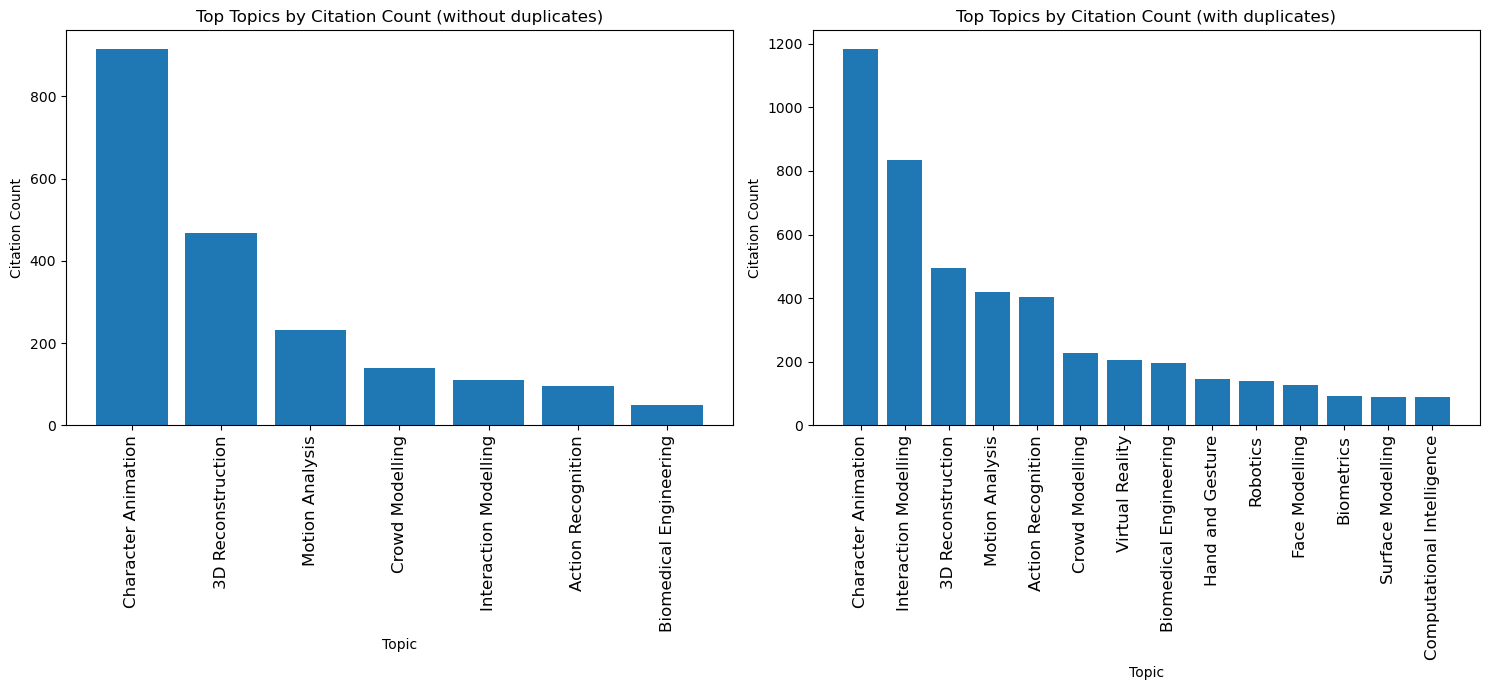

In [652]:
# First bar chart (with duplicates)
df_grouped = df_result.groupby(['Topic']).sum()
df_grouped = df_grouped.sort_values(by='Citation', ascending=False)

top_topics = df_grouped.index
citations = df_grouped['Citation']

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].bar(top_topics, citations)
axs[0].set_xlabel("Topic")
axs[0].set_ylabel("Citation Count")
axs[0].set_title("Top Topics by Citation Count (without duplicates)")
axs[0].set_xticklabels(top_topics, rotation=90, fontsize=12)

# Second bar chart (duplicates)
df_grouped = every_df.groupby(['Topic']).sum()
df_grouped = df_grouped.sort_values(by='Citation', ascending=False)

top_topics = df_grouped.index
citations = df_grouped['Citation']

axs[1].bar(top_topics, citations)
axs[1].set_xlabel("Topic")
axs[1].set_ylabel("Citation Count")
axs[1].set_title("Top Topics by Citation Count (with duplicates)")
axs[1].set_xticklabels(top_topics, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

#### Explanation:

  * From the above analysis, I have conducted three pieces of analysis. First, I sorted the dataframe 'clean_df' by the 'Citation' column in descending order and selected the top 25 rows. The result was stored in 'df_result' and only the 'Title' and 'Citation' columns were kept. In the second analysis, I included four more columns: impact factor, number of LDO, topic name, and year. Similarly, I sorted these columns by 'Citation' in descending order to try to find patterns, such as which topic titles are most cited and the reason behind it.

    Lastly, I plotted two bar charts to show the citations of each topic and to find which topic has the highest citations. However, in the data cleaning section above, 58 research papers were categorized into several topics. Based on that, I produced two bar charts. One chart shows the topics with no duplicates; I deleted the title that was mentioned a second time in the later topic category. In the second chart, I showed all the research papers, including duplicates, hence the reason the citation counts are higher.

    Based on this analysis, it is clear that research papers with the 'Character Animation' topic are highly cited across different years. This could be because those research papers have high LDO. For example, the research paper title 'Interaction Patches for Multi-Character Animation' has 7 LDOs, while other titles have an average of 4 LDOs. This can conclude that the topic in 'Character Animation' is top-cited because of its high publicity.


### Q:2 
 * “Links,Downloads and Online Resources”,
 
 * Design and implement the solution to crawl necessary information, and then generate a scatter chart that shows the average number of LDO items against the year of publication. 
 
 * Show the name and number of the LDO items of the top 25 publications according to the LDO items. 
 
 ###### Explain your design and highlight any features

In [683]:
grouped_df = clean_df.groupby("Year").mean().sort_values("LDO_Num", ascending=False)
grouped_df = grouped_df.reset_index()
print(grouped_df[["Year", "LDO_Num"]])

    Year   LDO_Num
0   2009  4.000000
1   2011  4.000000
2   2008  3.800000
3   2020  3.428571
4   2013  3.000000
5   2007  3.000000
6   2021  2.866667
7   2014  2.750000
8   2012  2.750000
9   2010  2.666667
10  2019  2.461538
11  2018  2.333333
12  2016  2.285714
13  2022  2.166667
14  2017  2.166667
15  2015  2.000000
16  2006  1.500000


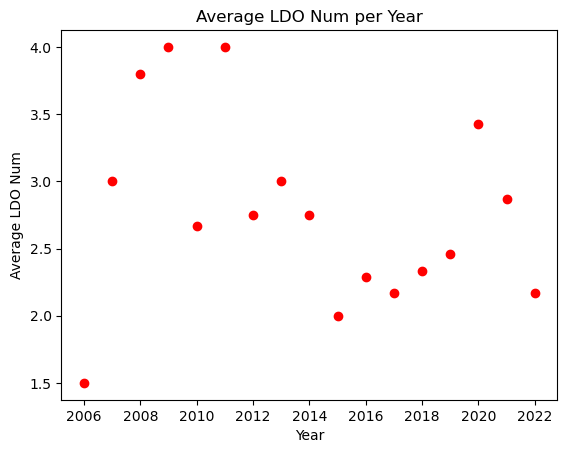

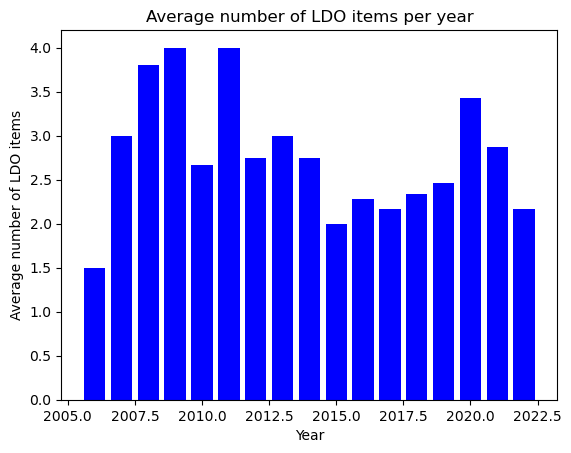

In [687]:
grouped_df = clean_df.groupby("Year").mean().sort_values("LDO_Num", ascending=False)

plt.scatter(grouped_df.index, grouped_df['LDO_Num'], color='red')
plt.xlabel("Year")
plt.ylabel("Average LDO Num")
plt.title("Average LDO Num per Year")
plt.show()

plt.bar(grouped_df.index, grouped_df['LDO_Num'], color='blue')
plt.xlabel("Year")
plt.ylabel("Average number of LDO items")
plt.title("Average number of LDO items per year")
plt.show()

In [701]:
grouped_df = clean_df.groupby("Year").mean().sort_values("LDO_Num", ascending=False)

Ldo_top_25 = clean_df.sort_values('LDO_Num', ascending=False).reset_index(drop=True).head(25)
group_topics = Ldo_top_25[['Topic','Title','LDO_Name','LDO_Num',]]
group = Ldo_top_25[['Title','LDO_Name','LDO_Num',]]
group

,Title,LDO_Name,LDO_Num
0,Interaction Patches for Mu...,"DOI - Publisher's Page, Pa...",7
1,DSPP: Deep Shape and Pose ...,"DOI - Publisher's Page, Pa...",5
2,Makeup Style Transfer on L...,"DOI - Publisher's Page, Pa...",5
3,Simulating Multiple Charac...,"DOI - Publisher's Page, Pa...",5
4,Foreground-aware Dense Dep...,"DOI - Publisher's Page, Pa...",5
5,Simulating Interactions of...,"DOI - Publisher's Page, Pa...",5
6,Resolving Hand-Object Occl...,"DOI - Publisher's Page, Pa...",5
7,360 Depth Estimation in th...,"Paper, Video Part 1, Video...",4
8,Data-Driven Crowd Motion C...,"DOI - Publisher's Page, Pa...",4
9,Real-Time Posture Reconstr...,"DOI - Publisher's Page, Pa...",4


                   Topic   LDO_Num
0    Character Animation  4.833333
1         Face Modelling  4.500000
2        Virtual Reality  4.500000
3      Surface Modelling  4.333333
4      3D Reconstruction  4.000000
5        Crowd Modelling  4.000000
6  Interaction Modelling  4.000000
7        Motion Analysis  4.000000
8               Robotics  4.000000


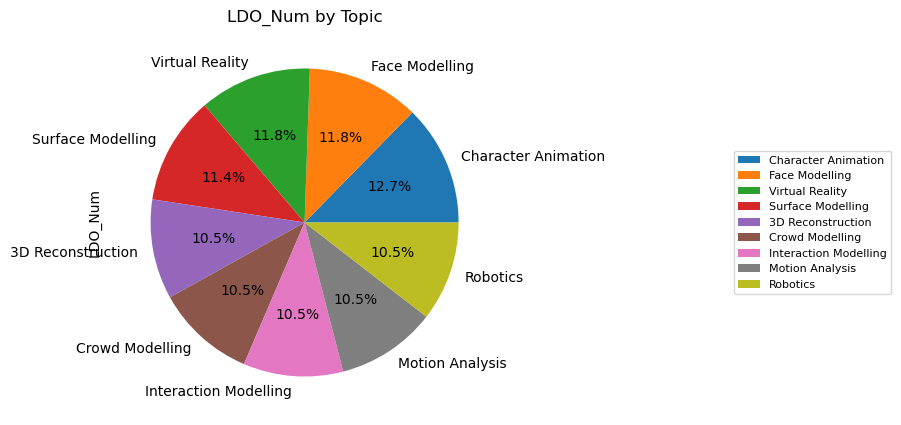

In [723]:
group_topic_df = group_topic.groupby("Topic").mean().sort_values("LDO_Num", ascending=False)
print(group_topic_df.reset_index())


group_topic_df.plot.pie(autopct='%1.1f%%', y="LDO_Num", figsize=(5, 5))

# # Reduce the font size of the labels in the chart

plt.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.6, 0.5))

plt.title("LDO_Num by Topic")
plt.show()

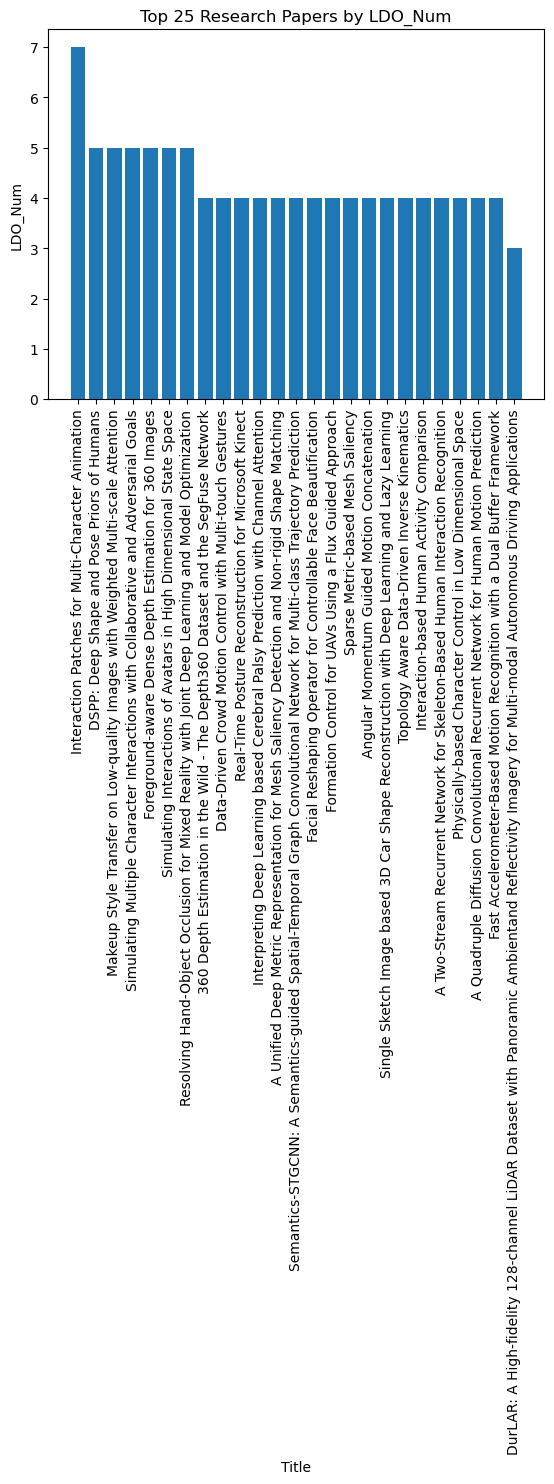

In [691]:
# get the x and y data
x = Ldo_top_25['Title']
y = Ldo_top_25['LDO_Num']

# create the bar plot
plt.bar(x, y)

# add labels and title
plt.xlabel('Title')
plt.ylabel('LDO_Num')
plt.title('Top 25 Research Papers by LDO_Num')

# rotate the x-axis labels to avoid overlap
plt.xticks(rotation=90)

# show the plot
plt.show()



#### Explanation:
 
   * This analysis displays the data in tables, scatter plots, pie chart and bar charts. At the beginning of this analysis, I have created a dataframe where I have scraped all the necessary data for different features. In this analysis, I select research paper title, LDO_Name and numbers from the clean_df data frame. 

   The first analysis focuses on the average number of LDO_num per year, which is obtained by grouping the data by year, finding the mean number of LDO per year, and sorting the values in descending order. The result is stored in a new dataframe that contains two columns: Year and LDO_Num.

   The second analysis involves plotting the data from the first analysis into scatter plots and bar charts. The scatter plot shows that there is no linear relationship between the two variables. The highest average LDO number is in 2009, with 4 LDOs on average for all papers in that year. The year with the lowest average LDO number is 2006, with 1.50.

   Finally, a table is created to rank the research papers by LDO number in descending order. The pie chart suggests that all 25 of the research papers with higher LDOs are from nine topics. The chart also shows that both the Virtual Reality and Face Modelling topics have the highest percentage of LDO numbers, both at 11.8%.


### Q:3 a) 
   * Sort the research topics related to the publications of the top ten 'highly cited' authors. 
      Analyse which authors collaborate (or appear) as co-authors in the publications based 
      on the research topics. Suggest the most popular topics where the authors collaborate 
      with each other. Justify and visualise your outcomes.
      
      * Topics - Author (top 10) - 'highly cited'
      * Author (appear) - as - co - auther - with topic
      * Topic (where authors collaborate most)

#### Topics - Author (top 10) - 'highly cited'

In [709]:
print(clean_df.head(4))

                 Topic                          Title  Citation  \
0  Character Animation  GAN-based Reactive Motion ...        21   
1  Character Animation  Spatio-temporal Manifold L...        48   
2  Character Animation  A Quadruple Diffusion Conv...       228   
3  Character Animation  A Generic Framework for Ed...         9   

   Impact_factor                       LDO_Name  LDO_Num  \
0          1.936  DOI - Publisher's Page, Pa...        3   
1          4.579  DOI - Publisher's Page, Pa...        3   
2          4.685  DOI - Publisher's Page, Pa...        4   
3          1.020  DOI - Publisher's Page, Pa...        3   

                          Auther   Vanue  Year  
0  Qianhui Men, Hubert P. H. ...  JOURAU  2022  
1  He Wang, Edmond S. L. Ho, ...  JOURAU  2021  
2  Qianhui Men, Edmond S. L. ...  JOURAU  2021  
3  Jacky C. P. Chan, Hubert P...  JOURAU  2019  


In [710]:
# print(clean_df.head(6))
print(clean_df[['Auther', 'Topic', 'Citation']].head(6))

                          Auther                Topic  Citation
0  Qianhui Men, Hubert P. H. ...  Character Animation        21
1  He Wang, Edmond S. L. Ho, ...  Character Animation        48
2  Qianhui Men, Edmond S. L. ...  Character Animation       228
3  Jacky C. P. Chan, Hubert P...  Character Animation         9
4  Naoya Iwamoto, Hubert P. H...  Character Animation        44
5  Liuyang Zhou, Lifeng Shang...  Character Animation        12


In [711]:
# saperated the each auther name from the authoer col
author_names = clean_df["Auther"].str.split(", ")
separate_authors = pd.DataFrame(author_names.tolist(), index=clean_df.index)
separate_authors = separate_authors.explode(0)
print(separate_authors)

                    0                  1                  2                 3  \
0         Qianhui Men  Hubert P. H. Shum    Edmond S. L. Ho      Howard Leung   
1             He Wang    Edmond S. L. Ho  Hubert P. H. Shum      Zhanxing Zhu   
2         Qianhui Men    Edmond S. L. Ho  Hubert P. H. Shum      Howard Leung   
3    Jacky C. P. Chan  Hubert P. H. Shum            He Wang           Wei Wei   
4       Naoya Iwamoto  Hubert P. H. Shum       Longzhi Yang  Shigeo Morishima   
..                ...                ...                ...               ...   
177      Lining Zhang  Hubert P. H. Shum          Ling Shao              None   
178            Jie Li  Hubert P. H. Shum      Graham Sexton      Longzhi Yang   
179           Yao Tan             Jie Li     Martin Wonders          Fei Chao   
180            Jie Li         Yanpeng Qu  Hubert P. H. Shum      Longzhi Yang   
181            Jie Li       Longzhi Yang  Hubert P. H. Shum     Graham Sexton   

                     4     

In [712]:
#Uniqe author contributed in different Topic
author_names = clean_df["Auther"].str.split(", ")
co_occurrence = []
for authors, topic in zip(author_names, clean_df["Topic"]):
    for author in authors:
        co_occurrence.append((author, topic))
co_occurrence_df = pd.DataFrame(co_occurrence, columns=["Author", "Topic"])
print(co_occurrence_df.head(10))

              Author                Topic
0        Qianhui Men  Character Animation
1  Hubert P. H. Shum  Character Animation
2    Edmond S. L. Ho  Character Animation
3       Howard Leung  Character Animation
4            He Wang  Character Animation
5    Edmond S. L. Ho  Character Animation
6  Hubert P. H. Shum  Character Animation
7       Zhanxing Zhu  Character Animation
8        Qianhui Men  Character Animation
9    Edmond S. L. Ho  Character Animation


In [713]:
#based on authoer name - Title
author_title_table = separate_authors.stack().reset_index(level=1, drop=True).to_frame('Author')
author_title_table = author_title_table.join(every_df.Title).reset_index()
author_title_table.dropna(inplace=True)
author_title_table = author_title_table.groupby(['Author', 'Title']).size().reset_index(name='Counts')
print(author_title_table)

                    Author                          Title  Counts
0    Abril Corona-Figueroa  MedNeRF: Medical Neural Ra...       1
1             Adam Barnett  Coordinated Crowd Simulati...       1
2           Akinori Nagano  Automatic Evaluation of Bo...       1
3          Alamgir Hossain  An Intelligent Mobile-Base...       1
4             Andreea Stef  Synthesizing Expressive Fa...       1
..                     ...                            ...     ...
479           Zhiguang Liu  Kinect Posture Reconstruct...       1
480           Zhiguang Liu  Posture Reconstruction Usi...       1
481           Zhiying Leng  Stable Hand Pose Estimatio...       1
482             Ziyi Chang  3D Reconstruction of Sculp...       1
483             Ziyi Chang  Denoising Diffusion Probab...       1

[484 rows x 3 columns]


In [714]:
author_title_table = separate_authors.stack().reset_index(level=1, drop=True).to_frame('Author')
author_title_table = author_title_table.join(clean_df[["Title", "Citation", "Topic"]]).reset_index()
author_title_table.dropna(inplace=True)
author_title_table = author_title_table.groupby(['Author', 'Title', 'Citation', 'Topic']).size().reset_index(name='Counts')
# print(author_title_table.head(3))

requerd_table = author_title_table[['Author', 'Topic', 'Citation']]
print(requerd_table)

                    Author                   Topic  Citation
0    Abril Corona-Figueroa  Biomedical Engineering         0
1             Adam Barnett         Crowd Modelling        41
2           Akinori Nagano         Motion Analysis         2
3          Alamgir Hossain  Biomedical Engineering         8
4             Andreea Stef          Face Modelling        21
..                     ...                     ...       ...
479           Zhiguang Liu       3D Reconstruction        98
480           Zhiguang Liu       3D Reconstruction        62
481           Zhiying Leng         Virtual Reality        31
482             Ziyi Chang       3D Reconstruction         0
483             Ziyi Chang     Character Animation         0

[484 rows x 3 columns]


In [724]:
# Group the author_title_table dataframe by author and calculate the sum of citations for each author
grouped = author_title_table.groupby("Author")["Citation"].sum().reset_index()


# Sort the resulting dataframe in descending order based on the sum of citations
grouped = grouped.sort_values("Citation", ascending=False)

# Add a column to the dataframe that represents the rank of each author
grouped["Rank"] = range(1, len(grouped) + 1)
# print(grouped)

# organising the datafram
grouped = grouped[["Rank", "Author", "Citation"]]
grouped.reset_index(drop=True, inplace=True)
# print(grouped.head(10))

author_topic = author_title_table.groupby('Author')['Topic'].apply(lambda x: ', '.join(np.unique(x)))
# print(author_topic)
#convert the grouped data into a dataframe and keep only the necessary columns; and give them the label
author_topic_df = author_topic.to_frame().reset_index()
author_topic_df = author_topic_df[['Author', 'Topic']]
print(author_topic_df)

# Merge the resulting dataframe with the author_title_table dataframe to get the topic names
result = pd.merge(grouped, author_topic_df, on="Author")

# # Keep only the columns you want in the final table
result = result[["Rank", "Author", "Citation", "Topic"]]

print(result.head(10))

grouped_by_topic = author_title_table.groupby("Topic")["Citation"].sum().reset_index()
print(grouped_by_topic)


                    Author                          Topic
0    Abril Corona-Figueroa         Biomedical Engineering
1             Adam Barnett                Crowd Modelling
2           Akinori Nagano                Motion Analysis
3          Alamgir Hossain         Biomedical Engineering
4             Andreea Stef                 Face Modelling
..                     ...                            ...
118            Zheming Zuo             Action Recognition
119            Zhigeng Pan             Action Recognition
120           Zhiguang Liu              3D Reconstruction
121           Zhiying Leng                Virtual Reality
122             Ziyi Chang  3D Reconstruction, Charact...

[123 rows x 2 columns]
   Rank             Author  Citation                          Topic
0     1  Hubert P. H. Shum      3266  3D Reconstruction, Action ...
1     2    Edmond S. L. Ho      1140  3D Reconstruction, Action ...
2     3        Taku Komura      1052  3D Reconstruction, Action ...
3     4 

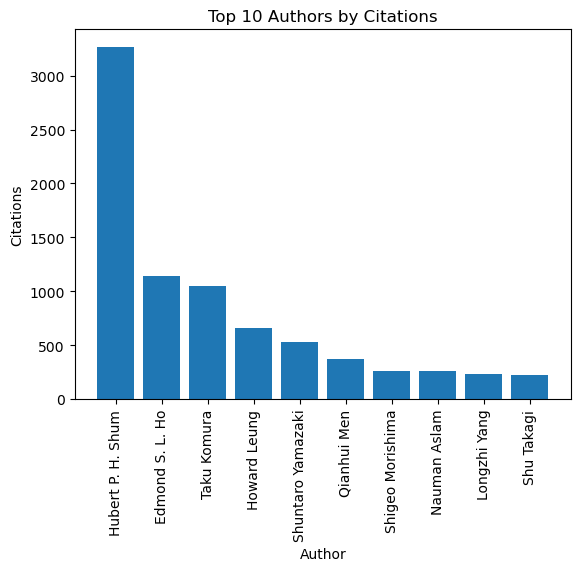

In [716]:
# Extract the top 10 authors
top_10 = result.head(10)

# Plot the bar chart
plt.bar(top_10["Author"], top_10["Citation"])

# Add labels and title
plt.xlabel("Author")
plt.ylabel("Citations")
plt.title("Top 10 Authors by Citations")
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [592]:
author_name = "Hubert P. H. Shum"
author_topics = author_topic[author_topic.index == author_name].values[0]
print(author_name + " has published in the following topics: " + author_topics)

Hubert P. H. Shum has published in the following topics: 3D Reconstruction, Action Recognition, Biomedical Engineering, Biometrics, Character Animation, Computational Intelligence, Crowd Modelling, Face Modelling, Interaction Modelling, Motion Analysis, Robotics, Surface Modelling, Virtual Reality


In [718]:
grouped = requerd_table.groupby(["Author", "Topic"])["Citation"].sum().reset_index()
print(grouped.head(10))

                   Author                   Topic  Citation
0   Abril Corona-Figueroa  Biomedical Engineering         0
1            Adam Barnett         Crowd Modelling        41
2          Akinori Nagano         Motion Analysis         2
3         Alamgir Hossain  Biomedical Engineering         8
4            Andreea Stef          Face Modelling        21
5  Anne-Sophie Le Pierres         Motion Analysis        45
6          Antoine Muller         Motion Analysis        31
7       Antonio Mucherino       Surface Modelling         2
8      Arghya Chakraborty          Face Modelling         9
9             Arindam Kar          Face Modelling         9


In [719]:
authors = ['Hubert P. H. Shum', 'Edmond S. L. Ho', 'Taku Komura', 'Howard Leung', 'Shuntaro Yamazaki','Qianhui Men', 'Shigeo Morishima', 'Nauman Aslam', 'Longzhi Yang', 'Shu Takagi']
grouped = grouped[grouped['Author'].isin(authors)]
grouped = grouped.pivot(index='Author', columns='Topic', values='Citation')
grouped = grouped.fillna(0)
grouped

Topic,3D Reconstruction,Action Recognition,Biomedical Engineering,Biometrics,Character Animation,Computational Intelligence,Crowd Modelling,Face Modelling,Interaction Modelling,Motion Analysis,Robotics,Surface Modelling,Virtual Reality
Author,,,,,,,,,,,,,
Edmond S. L. Ho,172.0,29.0,0.0,11.0,454.0,0.0,42.0,41.0,111.0,263.0,4.0,12.0,1.0
Howard Leung,160.0,119.0,0.0,0.0,261.0,0.0,0.0,0.0,60.0,55.0,0.0,0.0,0.0
Hubert P. H. Shum,494.0,256.0,81.0,49.0,1183.0,88.0,228.0,116.0,112.0,420.0,41.0,22.0,176.0
Longzhi Yang,0.0,10.0,0.0,0.0,45.0,48.0,0.0,10.0,0.0,123.0,0.0,0.0,0.0
Nauman Aslam,0.0,40.0,71.0,23.0,0.0,0.0,8.0,40.0,0.0,58.0,0.0,20.0,0.0
Qianhui Men,0.0,0.0,0.0,0.0,249.0,0.0,5.0,0.0,60.0,55.0,0.0,0.0,0.0
Shigeo Morishima,82.0,0.0,0.0,0.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0
Shu Takagi,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,33.0
Shuntaro Yamazaki,0.0,0.0,0.0,0.0,527.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


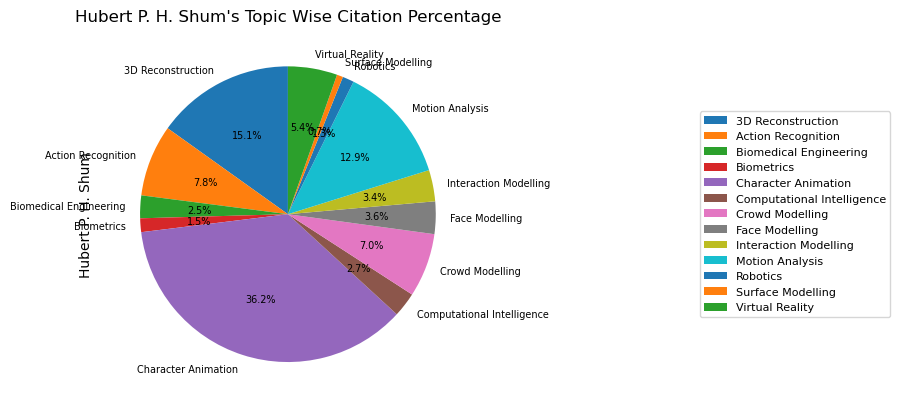

In [722]:
# Select the data for a single author
author_data = grouped.loc["Hubert P. H. Shum"]

# Plot the data as a pie chart
author_data.plot.pie(autopct='%1.1f%%', startangle=90, fontsize=7)
# author_data.plot.pie(autopct='%1.1f%%', labels=[])

# Add a title to the chart
plt.title("Hubert P. H. Shum's Topic Wise Citation Percentage")

# # Reduce the font size of the labels in the chart
plt.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.6, 0.5))

# Display the chart
plt.show()

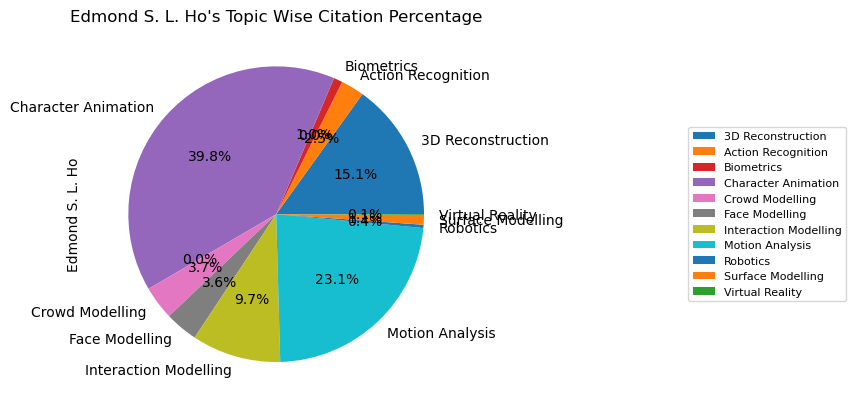

In [596]:
# Select the data for a single author
author_data = grouped.loc["Edmond S. L. Ho"]

# Plot the data as a pie chart
author_data.plot.pie(autopct='%1.1f%%')

# Add a title to the chart
plt.title("Edmond S. L. Ho's Topic Wise Citation Percentage")

# # Reduce the font size of the labels in the chart
plt.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.6, 0.5))

# Display the chart
plt.show()

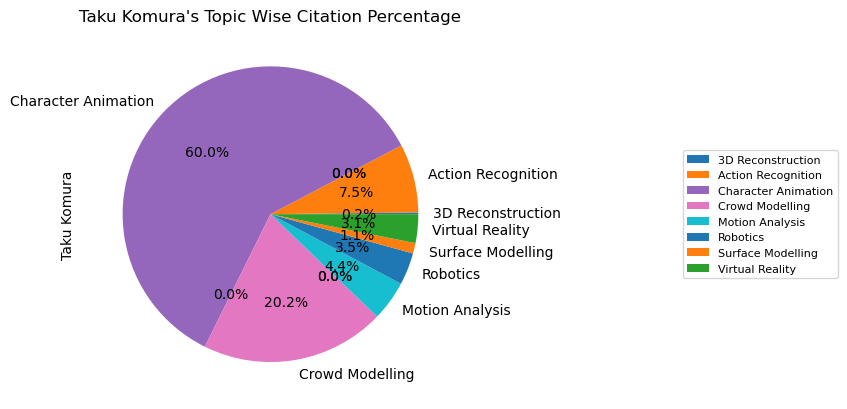

In [597]:
# Select the data for a single author
author_data = grouped.loc["Taku Komura"]

# Plot the data as a pie chart
author_data.plot.pie(autopct='%1.1f%%')

# Add a title to the chart
plt.title("Taku Komura's Topic Wise Citation Percentage")

# # Reduce the font size of the labels in the chart
plt.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.6, 0.5))

# Display the chart
plt.show()

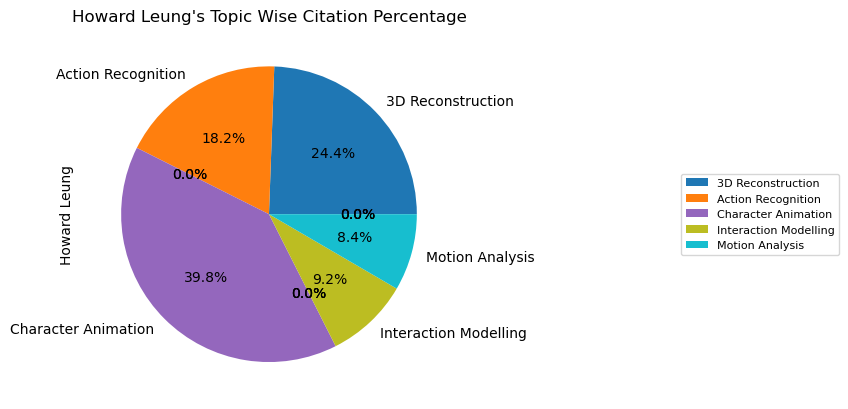

In [598]:
# Select the data for a single author
author_data = grouped.loc["Howard Leung"]

# Plot the data as a pie chart
author_data.plot.pie(autopct='%1.1f%%')

# Add a title to the chart
plt.title("Howard Leung's Topic Wise Citation Percentage")

# # Reduce the font size of the labels in the chart
plt.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.6, 0.5))

# Display the chart
plt.show()

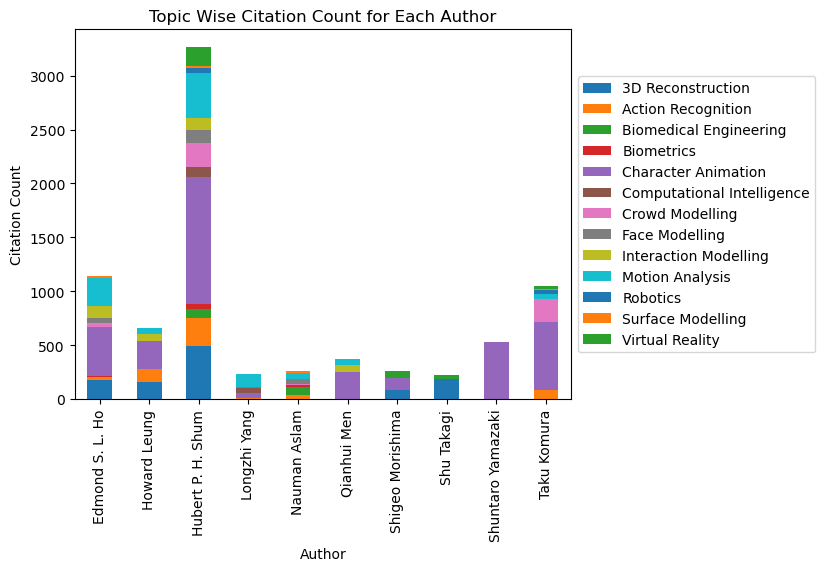

In [599]:
grouped.plot(kind='bar', stacked=True)
plt.xlabel("Author")
plt.ylabel("Citation Count")
plt.title("Topic Wise Citation Count for Each Author")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

 #### Author (appear) - as - co - auther - with topic

In [600]:
print(clean_df[['Topic','Title','Auther', ]].head(20))

        Topic      Title     Auther
0   Charac...  GAN-ba...  Qianhu...
1   Charac...  Spatio...  He Wan...
2   Charac...  A Quad...  Qianhu...
3   Charac...  A Gene...  Jacky ...
4   Charac...  Multi-...  Naoya ...
5   Charac...  Human ...  Liuyan...
6   Charac...  Topolo...  Edmond...
7   Charac...  Natura...  Hubert...
8   Charac...  Simula...  Hubert...
9   Charac...  Angula...  Hubert...
10  Charac...  Intera...  Hubert...
11  Charac...  Automa...  Naoya ...
12  Charac...  DanceD...  Naoya ...
13  Charac...  Synthe...  Edmond...
14  Charac...  Prepar...  Hubert...
15  Charac...  Real-t...  Hubert...
16  Charac...  Simula...  Hubert...
17  Charac...  Simula...  Taku K...
18  Charac...  Simula...  Hubert...
19  Charac...  Denois...  Haozhe...


In [601]:
author_names = clean_df["Auther"].str.split(", ")
grouped = clean_df.groupby("Topic")
for name, group in grouped:
    print(f"Topic: {name}")
    co_occurrence_matrix = {}
    author_names = group["Auther"].str.split(", ")
    for authors in author_names:
        for author1, author2 in itertools.combinations(sorted(authors), 2):
            if author1 not in co_occurrence_matrix:
                co_occurrence_matrix[author1] = {}
            if author2 not in co_occurrence_matrix[author1]:
                co_occurrence_matrix[author1][author2] = 0
            co_occurrence_matrix[author1][author2] += 1
    print("Co-occurrence Matrix:")
#     print("Co-occurrence Matrix:")
    for author1, co_authors in co_occurrence_matrix.items():
        for author2, count in sorted(co_authors.items(), key=lambda x: x[1], reverse=True):
            print(f"\t{author1} and {author2} appeared together as co-authors {count} times")



Topic: 3D Reconstruction
Co-occurrence Matrix:
	Edmond S. L. Ho and Hubert P. H. Shum appeared together as co-authors 5 times
	Edmond S. L. Ho and Naoki Nozawa appeared together as co-authors 3 times
	Edmond S. L. Ho and Shigeo Morishima appeared together as co-authors 3 times
	Edmond S. L. Ho and Qi Feng appeared together as co-authors 1 times
	Edmond S. L. Ho and Shu Takagi appeared together as co-authors 1 times
	Edmond S. L. Ho and Yang Jiang appeared together as co-authors 1 times
	Edmond S. L. Ho and Jingtian Zhang appeared together as co-authors 1 times
	Edmond S. L. Ho and Kevin D. McCay appeared together as co-authors 1 times
	Hubert P. H. Shum and Shigeo Morishima appeared together as co-authors 6 times
	Hubert P. H. Shum and Qi Feng appeared together as co-authors 4 times
	Hubert P. H. Shum and Naoki Nozawa appeared together as co-authors 3 times
	Hubert P. H. Shum and Liuyang Zhou appeared together as co-authors 2 times
	Hubert P. H. Shum and Zhiguang Liu appeared together 

In [602]:
author_names = clean_df["Auther"].str.split(", ")
grouped = clean_df.groupby("Topic")
for name, group in grouped:
    print(f"Topic: {name}")
    co_occurrence_matrix = {}
    author_names = group["Auther"].str.split(", ")
    for authors in author_names:
        for author1, author2 in itertools.combinations(sorted(authors), 2):
            if author1 not in co_occurrence_matrix:
                co_occurrence_matrix[author1] = {}
            if author2 not in co_occurrence_matrix[author1]:
                co_occurrence_matrix[author1][author2] = 0
            co_occurrence_matrix[author1][author2] += 1
            
            
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix).fillna(0).astype(int)
    co_occurrence_df = co_occurrence_df.sum().sort_values(ascending=False)
    print("Co-occurrence Matrix:")
    for author1, count in co_occurrence_df.items():
        print(f"\t{author1} appeared as a co-author {count} times")
    print("\n\n")

Topic: 3D Reconstruction
Co-occurrence Matrix:
	Hubert P. H. Shum appeared as a co-author 28 times
	Edmond S. L. Ho appeared as a co-author 16 times
	Howard Leung appeared as a co-author 6 times
	Naoki Nozawa appeared as a co-author 4 times
	Qi Feng appeared as a co-author 4 times
	Franck Multon appeared as a co-author 2 times
	Liuyang Zhou appeared as a co-author 2 times
	Khalid N. Ismail appeared as a co-author 2 times
	Shu Takagi appeared as a co-author 1 times
	Li Li appeared as a co-author 1 times
	Kevin Mackay appeared as a co-author 1 times
	Jingtian Zhang appeared as a co-author 1 times



Topic: Action Recognition
Co-occurrence Matrix:
	Hubert P. H. Shum appeared as a co-author 27 times
	Howard Leung appeared as a co-author 12 times
	Edmond S. L. Ho appeared as a co-author 7 times
	Nauman Aslam appeared as a co-author 6 times
	Donald C. K. Chan appeared as a co-author 5 times
	Jingtian Zhang appeared as a co-author 4 times
	Daniel Organisciak appeared as a co-author 3 times
	M

In [725]:
author_names = clean_df["Auther"].str.split(", ")
grouped = clean_df.groupby("Topic")

for name, group in grouped:
    co_occurrence_matrix = {}
    author_names = group["Auther"].str.split(", ")
    for authors in author_names:
        for author1, author2 in itertools.combinations(sorted(authors), 2):
            if author1 not in co_occurrence_matrix:
                co_occurrence_matrix[author1] = {}
            if author2 not in co_occurrence_matrix[author1]:
                co_occurrence_matrix[author1][author2] = 0
            co_occurrence_matrix[author1][author2] += 1
    
    # Sum the co-occurrence count for each author
    author_count = {}
    for author1, co_authors in co_occurrence_matrix.items():
        author_count[author1] = sum(co_authors.values())
    
    # Create a table from the co-occurrence matrix
    co_occurrence_df = pd.DataFrame.from_dict(author_count, orient='index', columns=['Co-occurrence Count'])
    co_occurrence_df.reset_index(inplace=True)
    co_occurrence_df.rename(columns={'index': 'Author'}, inplace=True)
    co_occurrence_df.sort_values(by='Co-occurrence Count', ascending=False, inplace=True)
    
    print(f"Topic: {name}")
    print(co_occurrence_df)
    print("\n\n")

Topic: 3D Reconstruction
               Author  Co-occurrence Count
1   Hubert P. H. Shum                   28
0     Edmond S. L. Ho                   16
5        Howard Leung                    6
2        Naoki Nozawa                    4
3             Qi Feng                    4
4       Franck Multon                    2
6        Liuyang Zhou                    2
8    Khalid N. Ismail                    2
7          Shu Takagi                    1
9               Li Li                    1
10       Kevin Mackay                    1
11     Jingtian Zhang                    1



Topic: Action Recognition
                Author  Co-occurrence Count
1    Hubert P. H. Shum                   27
5         Howard Leung                   12
0      Edmond S. L. Ho                    7
2         Nauman Aslam                    6
7    Donald C. K. Chan                    5
3       Jingtian Zhang                    4
11  Daniel Organisciak                    3
13      Maxime Bouchee             

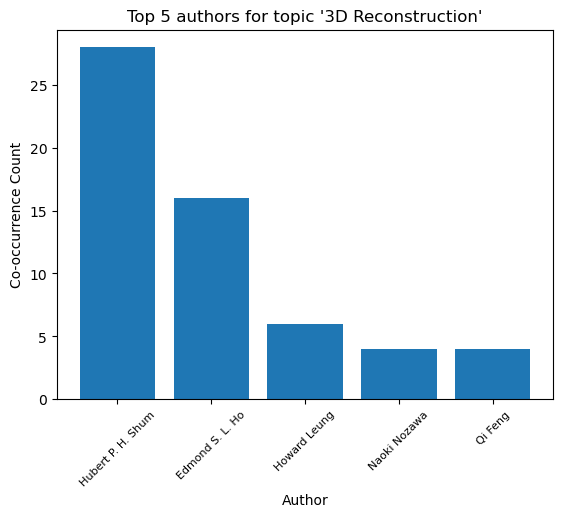

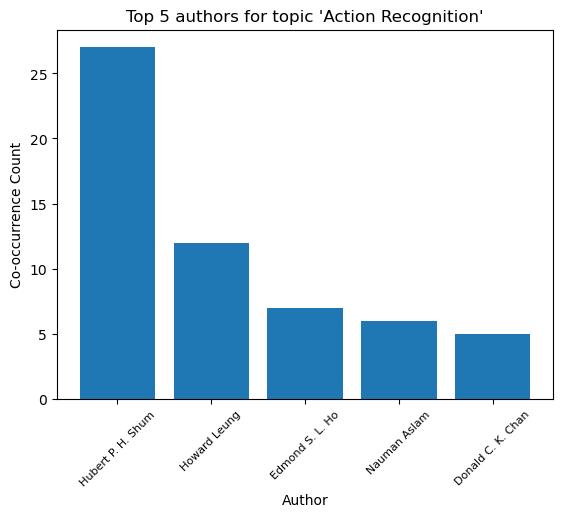

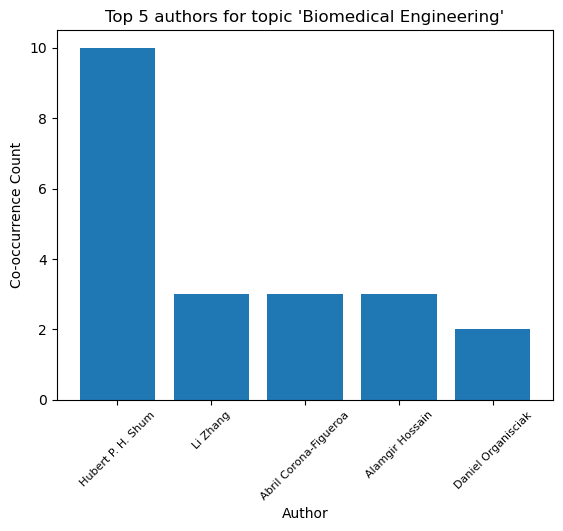

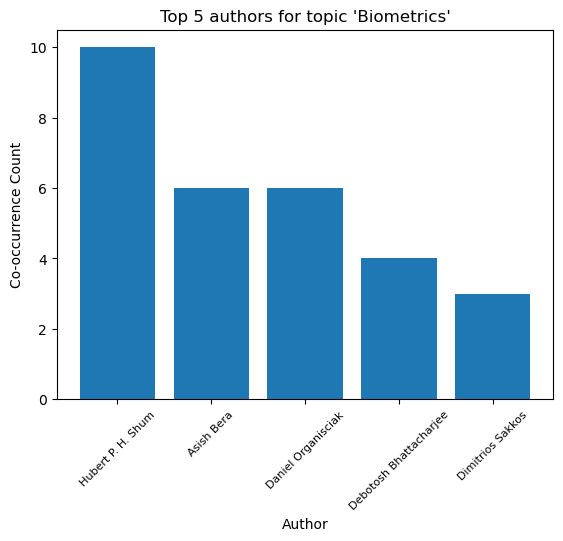

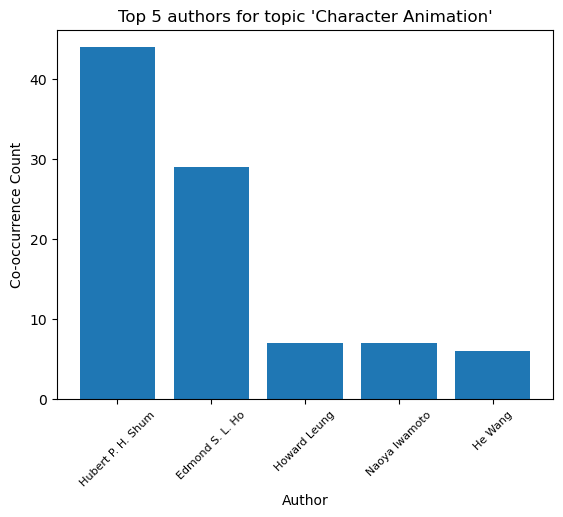

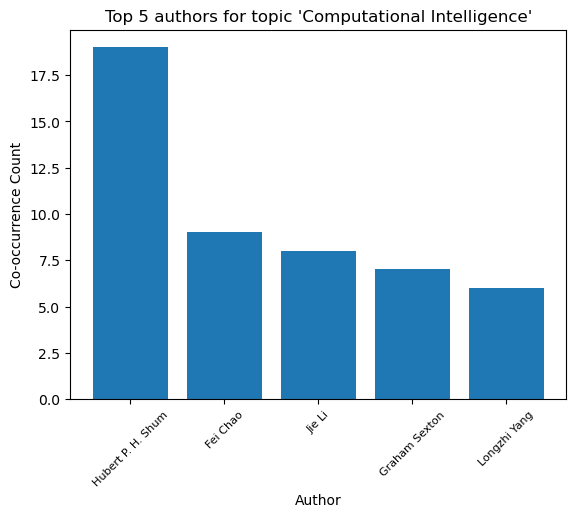

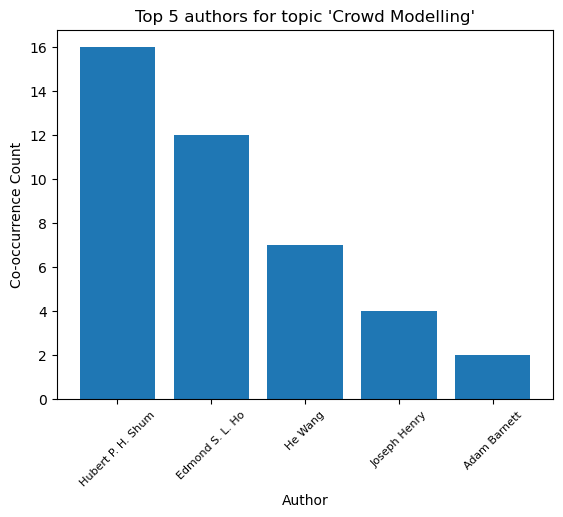

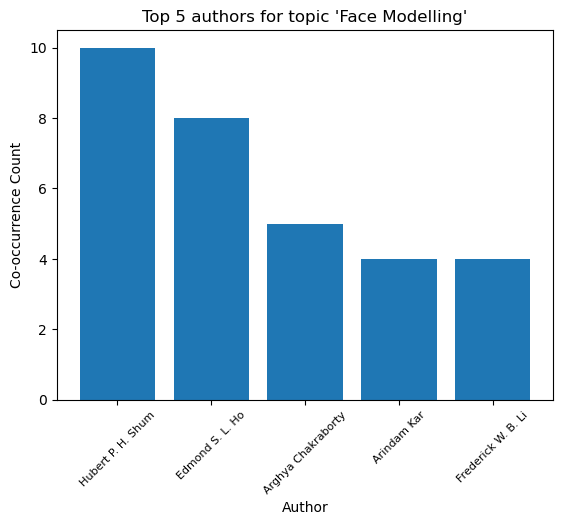

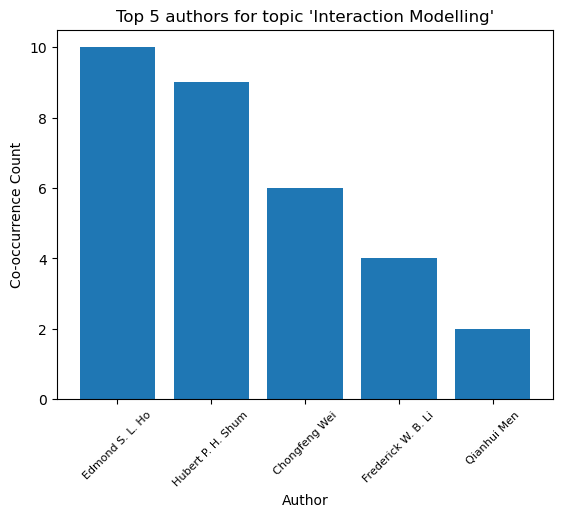

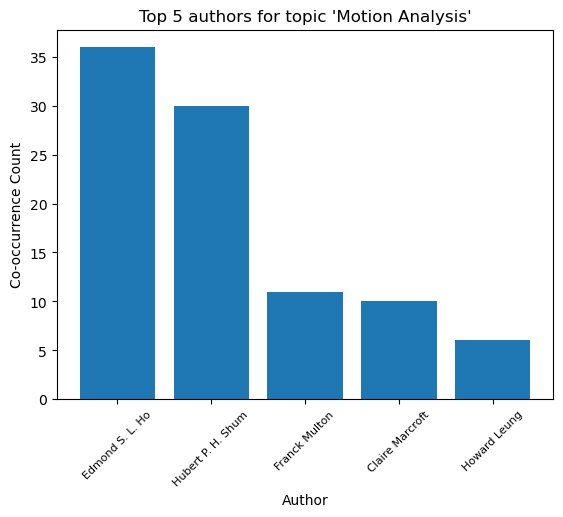

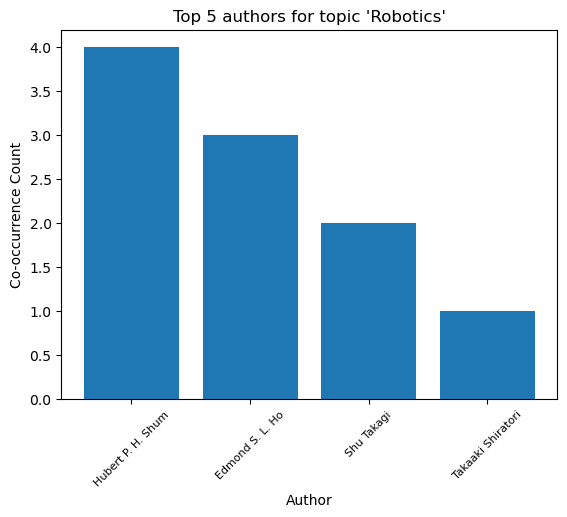

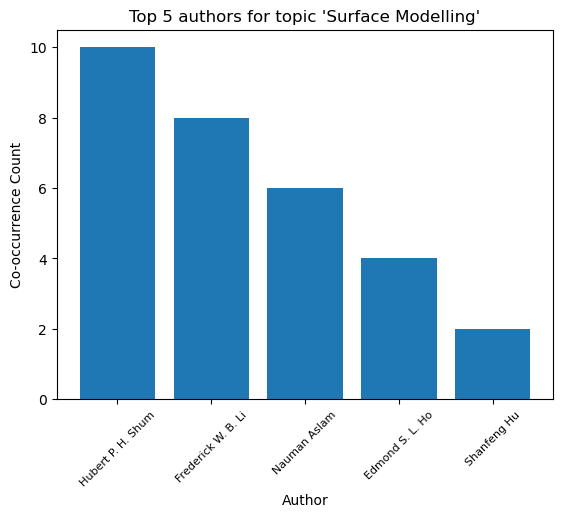

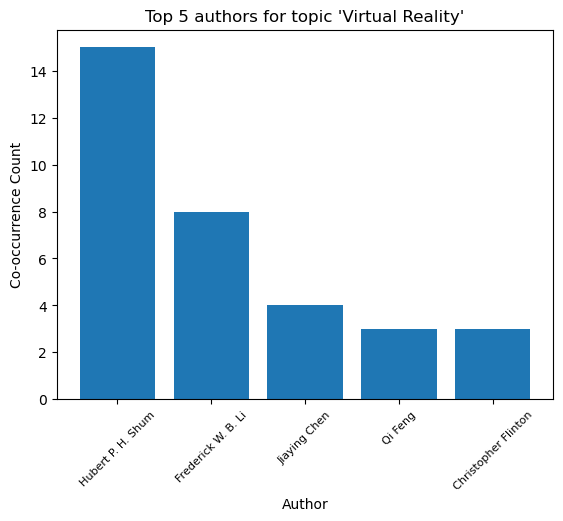

In [603]:
author_names = clean_df["Auther"].str.split(", ")
grouped = clean_df.groupby("Topic")

for name, group in grouped:
    co_occurrence_matrix = {}
    author_names = group["Auther"].str.split(", ")
    for authors in author_names:
        for author1, author2 in itertools.combinations(sorted(authors), 2):
            if author1 not in co_occurrence_matrix:
                co_occurrence_matrix[author1] = {}
            if author2 not in co_occurrence_matrix[author1]:
                co_occurrence_matrix[author1][author2] = 0
            co_occurrence_matrix[author1][author2] += 1

    # Sum the co-occurrence count for each author
    author_count = {}
    for author1, co_authors in co_occurrence_matrix.items():
        author_count[author1] = sum(co_authors.values())

    # Sort the authors by their count in descending order
    sorted_authors = sorted(author_count.items(), key=lambda x: x[1], reverse=True)

    # Plot the bar chart
    x = [author[0] for author in sorted_authors[:5]]
    y = [author[1] for author in sorted_authors[:5]]
    plt.bar(x, y)
    plt.title(f"Top 5 authors for topic '{name}'")
    plt.xlabel("Author")
    plt.ylabel("Co-occurrence Count")
    
    # Rotate x-axis labels and adjust font size
    plt.xticks(rotation=45, fontsize=8)
    plt.show()

#### Topic (where authors collaborate most)

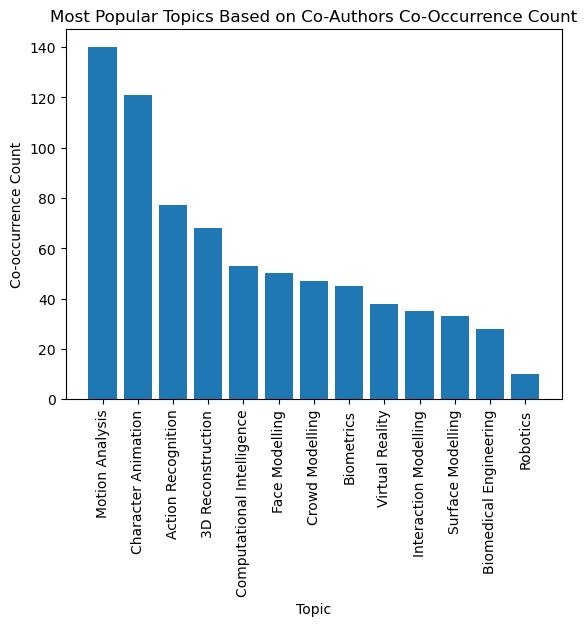

The most popular topic is 'Motion Analysis' with a total co-occurrence count of 140


In [604]:
# Count the co-occurrence count for each topic
topic_count = {}
grouped = clean_df.groupby("Topic")
for name, group in grouped:
    co_occurrence_matrix = {}
    author_names = group["Auther"].str.split(", ")
    for authors in author_names:
        for author1, author2 in itertools.combinations(sorted(authors), 2):
            if author1 not in co_occurrence_matrix:
                co_occurrence_matrix[author1] = {}
            if author2 not in co_occurrence_matrix[author1]:
                co_occurrence_matrix[author1][author2] = 0
            co_occurrence_matrix[author1][author2] += 1

    # Sum the co-occurrence count for each author
    author_count = {}
    for author1, co_authors in co_occurrence_matrix.items():
        author_count[author1] = sum(co_authors.values())

    # Sum the co-occurrence count for each topic
    topic_count[name] = sum(author_count.values())

# Sort the topics by their count in descending order
sorted_topics = sorted(topic_count.items(), key=lambda x: x[1], reverse=True)

# Plot the bar chart
x = [topic[0] for topic in sorted_topics]
y = [topic[1] for topic in sorted_topics]
plt.bar(x, y)
plt.title("Most Popular Topics Based on Co-Authors Co-Occurrence Count")
plt.xlabel("Topic")
plt.ylabel("Co-occurrence Count")
plt.xticks(rotation=90)
plt.show()

# Print the most popular topic
print(f"The most popular topic is '{sorted_topics[0][0]}' with a total co-occurrence count of {sorted_topics[0][1]}")

#### 3.b) 
   * Analyse the relationship between the features of the publication and the "citation" 
     count. Suggest the top three features that have the highest impact on the "citation" 
     count.

In [765]:
print(clean_df.head(6))

                 Topic                          Title  Citation  \
0  Character Animation  GAN-based Reactive Motion ...        21   
1  Character Animation  Spatio-temporal Manifold L...        48   
2  Character Animation  A Quadruple Diffusion Conv...       228   
3  Character Animation  A Generic Framework for Ed...         9   
4  Character Animation  Multi-layer Lattice Model ...        44   
5  Character Animation  Human Motion Variation Syn...        12   

   Impact_factor                       LDO_Name  LDO_Num  \
0          1.936  DOI - Publisher's Page, Pa...        3   
1          4.579  DOI - Publisher's Page, Pa...        3   
2          4.685  DOI - Publisher's Page, Pa...        4   
3          1.020  DOI - Publisher's Page, Pa...        3   
4          2.078  DOI - Publisher's Page, Pa...        3   
5          1.020  DOI - Publisher's Page, Pa...        3   

                          Auther   Vanue  Year  
0  Qianhui Men, Hubert P. H. ...  JOURAU  2022  
1  He Wang,

In [766]:
citation_df = clean_df.drop(columns=['Year'])

In [771]:
print(citation_df["Impact_factor"])

0       1.936
1       4.579
2       4.685
3       1.020
4       2.078
        ...  
177    10.856
178     0.000
179     0.000
180     0.000
181     0.000
Name: Impact_factor, Length: 128, dtype: float64


Number of features in test set: 286


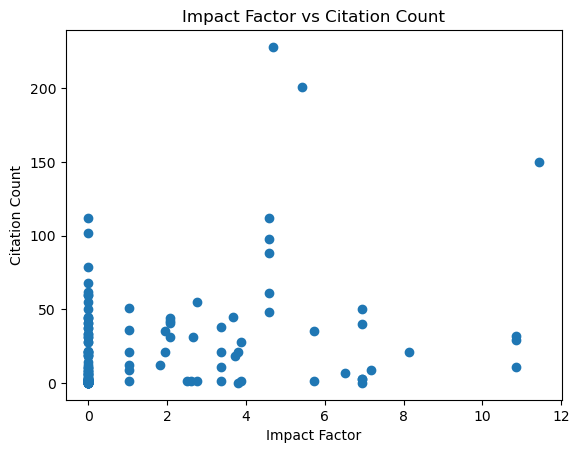

In [772]:
plt.scatter(x=citation_df["Impact_factor"], y=citation_df["Citation"])
plt.xlabel("Impact Factor")
plt.ylabel("Citation Count")
plt.title("Impact Factor vs Citation Count")
plt.show()

C:\Users\abidh\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Citation', ylabel='Density'>

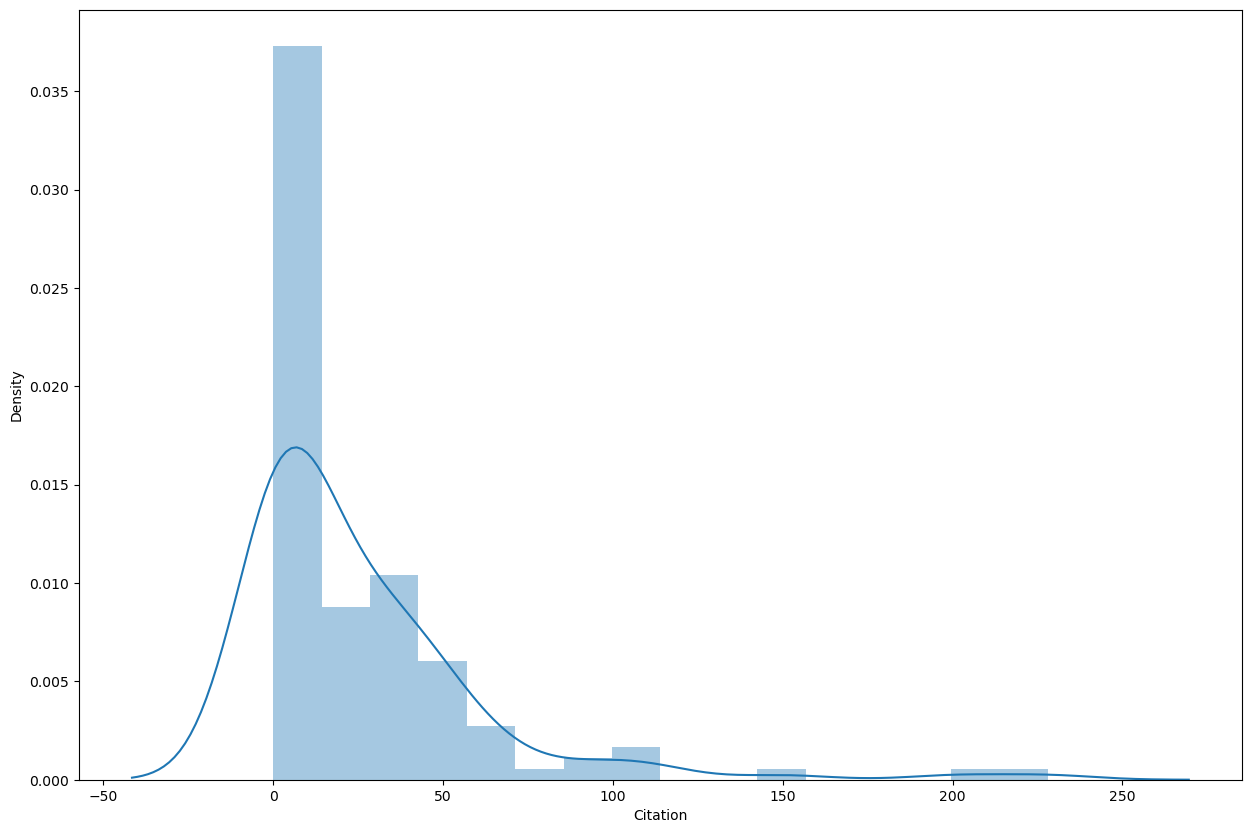

In [773]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(citation_df["Citation"])

In [793]:
reg = LinearRegression()

# Define the independent variables
X = pd.get_dummies(citation_df[["Topic", "Title", "Impact_factor", "LDO_Num", "Auther", "Vanue", "LDO_Name"]])

# Define the dependent variable
y = citation_df["Citation"]

print("Number of features in the data set:", X.shape[1])

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

coefs = results.params



Number of features in the data set: 286
                                                      Feature  Importance
Title_A Quadruple Diffusion...  Title_A Quadruple Diffusio...   75.682369
Auther_Qianhui Men, Edmond ...  Auther_Qianhui Men, Edmond...   75.682369
Title_Bi-projection based F...  Title_Bi-projection based ...   38.949349
Auther_Hubert P. H. Shum, T...  Auther_Hubert P. H. Shum, ...   38.867350
Title_Interaction Patches f...  Title_Interaction Patches ...   38.864692
Auther_Hubert P. H. Shum, T...  Auther_Hubert P. H. Shum, ...   38.864692
LDO_Name_DOI - Publisher's ...  LDO_Name_DOI - Publisher's...   38.864692
Title_Simulating Competitiv...  Title_Simulating Competiti...   31.572850
Title_Environment-aware Rea...  Title_Environment-aware Re...   26.457781
Auther_Joseph Henry, Hubert...  Auther_Joseph Henry, Huber...   26.227094


In [775]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Citation   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 14 Feb 2023   Prob (F-statistic):                nan
Time:                        09:30:34   Log-Likelihood:                 3567.7
No. Observations:                 128   AIC:                            -6879.
Df Residuals:                       0   BIC:                            -6514.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                             coef    std err          t      P>|t|      [0.025    

C:\Users\abidh\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\abidh\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\abidh\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


###### Top three features which has hight impact on citation

In [796]:
coefs = results.params
# Create a dataframe with the features and their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefs})

# Sort the feature importance dataframe by the Importance column in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Get the top three features
top_three_features = feature_importance.iloc[:3, :]

# Print the top three features
# print(top_three_features)
top_three_features

,Feature,Importance
Title_A Quadruple Diffusion Convolutional Recurrent Network for Human Motion Prediction,Title_A Quadruple Diffusio...,75.682369
"Auther_Qianhui Men, Edmond S. L. Ho, Hubert P. H. Shum, Howard Leung","Auther_Qianhui Men, Edmond...",75.682369
Title_Bi-projection based Foreground-aware Omnidirectional Depth Prediction,Title_Bi-projection based ...,38.949349


#### 3.c) 
   * Each publication is published in a specific type of venue (such as “journal” or 
     “conferernce”). You have to identify a specific feature "impact factor" for the 
      publications and analyse its relationship with the type of venue where the article has 
      been published.

In [618]:
clean_df

,Topic,Title,Citation,Impact_factor,LDO_Name,LDO_Num,Auther,Vanue,Year
0,Charac...,GAN-ba...,21,1.936,DOI - ...,3,Qianhu...,JOURAU,2022
1,Charac...,Spatio...,48,4.579,DOI - ...,3,He Wan...,JOURAU,2021
2,Charac...,A Quad...,228,4.685,DOI - ...,4,Qianhu...,JOURAU,2021
3,Charac...,A Gene...,9,1.020,DOI - ...,3,Jacky ...,JOURAU,2019
4,Charac...,Multi-...,44,2.078,DOI - ...,3,Naoya ...,JOURAU,2015
...,...,...,...,...,...,...,...,...,...
177,Comput...,Discri...,29,10.856,DOI - ...,2,Lining...,JOURAU,2016
178,Comput...,Experi...,6,0.000,DOI - ...,2,Jie Li...,CONFAU,2016
179,Comput...,Toward...,14,0.000,DOI - ...,2,Yao Ta...,CONFAU,2016
180,Comput...,TSK In...,6,0.000,DOI - ...,2,Jie Li...,CONFAU,2016


In [619]:
impact_df = clean_df[['Vanue', 'Impact_factor']]

In [620]:
impact_df

,Vanue,Impact_factor
0,JOURAU,1.936
1,JOURAU,4.579
2,JOURAU,4.685
3,JOURAU,1.020
4,JOURAU,2.078
...,...,...
177,JOURAU,10.856
178,CONFAU,0.000
179,CONFAU,0.000
180,CONFAU,0.000


In [743]:
grouped_ffff = impact_df.groupby('Vanue')['Impact_factor'].sum().reset_index()
print(grouped_ffff)

        Vanue  Impact_factor
0      CHAPAU          0.000
1      CONFAU          0.000
2       GENAU          0.000
3      JOURAU        214.644
4  PreprintAU          0.000
5      THESAU          0.000


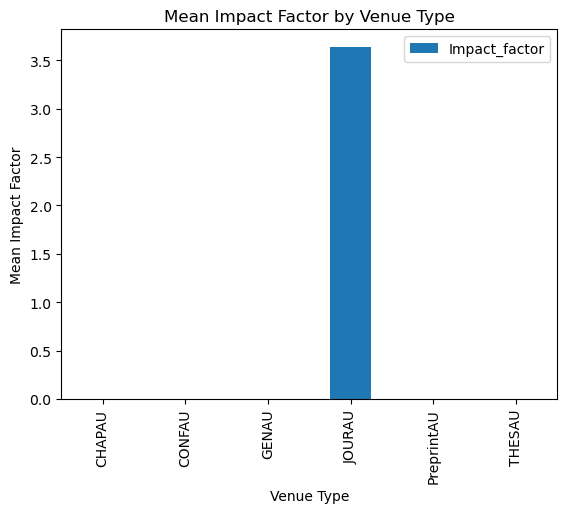

In [622]:
impact_df = clean_df[['Vanue', 'Impact_factor']]
grouped = impact_df.groupby('Vanue').mean()
grouped.plot.bar()
plt.xlabel('Venue Type')
plt.ylabel('Mean Impact Factor')
plt.title('Mean Impact Factor by Venue Type')
plt.show()

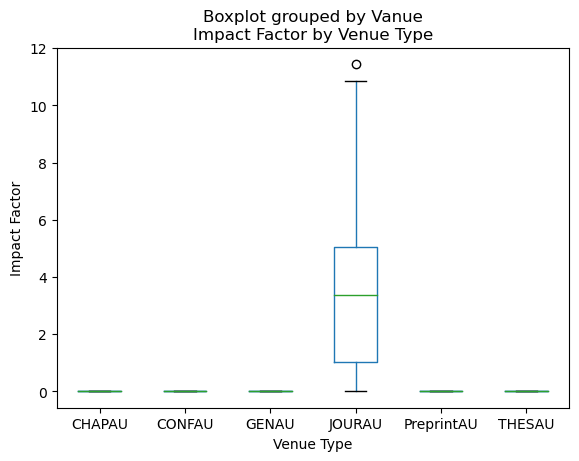

In [729]:
impact_df = clean_df[['Vanue', 'Impact_factor']]
impact_df.boxplot(by='Vanue', column=['Impact_factor'], grid=False)
plt.xlabel('Venue Type')
plt.ylabel('Impact Factor')
plt.title('Impact Factor by Venue Type')
plt.show()

In [810]:
# Convert the categorical variable "Vanue" into numerical variables using one-hot encoding
ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(impact_df[["Vanue"]]).toarray()

# Split the data into training and testing sets
X = X_encoded
y = impact_df["Impact_factor"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



# Add a constant to the input data to account for the intercept term
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

print("Number of features in training set:", X_train.shape[1])
print("Number of features in test set:", X_test.shape[1])

# Fit the OLS regression model
model = sm.OLS(y_train, X_train).fit()

# Make predictions on the testing set
y_pred = model.predict(X_test)

print(model.summary())


# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("mean_squared_error: ",mse)
print("root mean squared error (RMSE): ", rmse)
print("R-squared score: ", r2)

Number of features in training set: 7
Number of features in test set: 7
                            OLS Regression Results                            
Dep. Variable:          Impact_factor   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     16.90
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           1.52e-10
Time:                        10:05:36   Log-Likelihood:                -218.45
No. Observations:                 102   AIC:                             446.9
Df Residuals:                      97   BIC:                             460.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Explanation 
   *  The first part of this analysis focuses on the research paper data which includes authors, topics, and citations. The goal is to answer three questions related to the data. The first question involves finding the top 10 highly cited authors in each topic. The data is cleaned by splitting author names and creating a separate dataframe for authors. The co-occurrence of authors and topics is then calculated and the authors are grouped based on their contributions. The total citations received by each author are calculated and the data is sorted in descending order based on the number of citations. Graphs are plotted to visualize the data. The results show that author Hubert P. H. Shum has the highest number of citations with 3,266.
   
    The second question of the first part involves analyzing the co-authorship of researchers in different research topics. The results show that Hubert P. H. Shum has the highest co-occurrence count, with a count of 30 in the topic of Motion Analysis. The third question of the first part shows that the most popular topic is Motion Analysis with a total co-occurrence count of 140 times.
    
    The second part of the analysis focuses on the statistical relationship between the dependent variable, "Citation," and the independent variables listed in the "Feature" column. The analysis shows that "Title" and "Author" have the highest importance for "Citation" with 75% each.
    In the last relationship analysis, an OLS regression model was built to predict the value of the dependent variable based on the values of the independent variables. The results suggest that the "Journal" has a weak relationship with the "Impact Factor," as the p-value is 1.00, which is greater than 0.05, indicating that it is not significant.
    The performance of the prediction model is measured by the mean squared error (MSE), which is 3.76. This means that on average, the difference between the actual and predicted values of "Impact Factor" is approximately 3.76 units. The R-squared score of 0.54 indicates that 54% of the variance in the target variable can be explained by the model.






#### Q: 4
 
 * Design and implement the solution to perform analysis to identify the 
    uncertain and complex inter-dependencies between Covid-19 symptoms and validate the 
    prediction of the severity of Covid-19 and its determinants probabilistically. 
    
  
 * Justify the design choice and showcase the findings using an appropriate visualisation tool. Explain your design, 
   highlight features, and showcase your findings in no more than 200 words.

#### Load libraries

In [949]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn

In [950]:
# Import data
df=pd.read_csv('covid.csv', sep=',', header=0)

df.head()

,id,headache,lossOfSmell,musclePain,cough,soreThroat,chestPain,fever,hoarseness,lossOfAppetite,diarrhea,fatigue,confusion,shortnessOfBreath,AbdominalPain,level
0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,2
2,2,1,1,0,0,1,1,0,0,1,1,0,0,0,0,3
3,3,1,1,0,1,0,1,1,1,0,1,1,0,0,0,4
4,4,1,1,1,1,1,1,1,1,1,0,1,1,0,0,5


In [951]:
# Remove any duplicates
df = df.drop_duplicates()
df = df.drop(columns=["id"])

In [952]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
headache,200000.0,0.714715,0.451551,0.0,0.0,1.0,1.0,1.0
lossOfSmell,200000.0,0.714290,0.451753,0.0,0.0,1.0,1.0,1.0
musclePain,200000.0,0.571470,0.494867,0.0,0.0,1.0,1.0,1.0
cough,200000.0,0.642715,0.479201,0.0,0.0,1.0,1.0,1.0
soreThroat,200000.0,0.642940,0.479134,0.0,0.0,1.0,1.0,1.0
chestPain,200000.0,0.642990,0.479119,0.0,0.0,1.0,1.0,1.0
fever,200000.0,0.571660,0.494839,0.0,0.0,1.0,1.0,1.0
hoarseness,200000.0,0.572810,0.494672,0.0,0.0,1.0,1.0,1.0
lossOfAppetite,200000.0,0.572065,0.494781,0.0,0.0,1.0,1.0,1.0
diarrhea,200000.0,0.501635,0.499999,0.0,0.0,1.0,1.0,1.0


In [953]:
for i in df.columns:
    print("\nColumn Name:",i,"-->",df[i].unique(),"-->Unique Count",len(df[i].unique()))


Column Name: headache --> [1 0] -->Unique Count 2

Column Name: lossOfSmell --> [1 0] -->Unique Count 2

Column Name: musclePain --> [1 0] -->Unique Count 2

Column Name: cough --> [1 0] -->Unique Count 2

Column Name: soreThroat --> [1 0] -->Unique Count 2

Column Name: chestPain --> [1 0] -->Unique Count 2

Column Name: fever --> [0 1] -->Unique Count 2

Column Name: hoarseness --> [0 1] -->Unique Count 2

Column Name: lossOfAppetite --> [0 1] -->Unique Count 2

Column Name: diarrhea --> [0 1] -->Unique Count 2

Column Name: fatigue --> [0 1] -->Unique Count 2

Column Name: confusion --> [0 1] -->Unique Count 2

Column Name: shortnessOfBreath --> [0 1] -->Unique Count 2

Column Name: AbdominalPain --> [0 1] -->Unique Count 2

Column Name: level --> [1 2 3 4 5 6 0] -->Unique Count 7


#### Define funtion to discretise data into catagories

In [955]:
#variable converting to discrete
def make_discrete(df):
    discrete_df = pd.DataFrame()
    
    columns = ['headache', 'lossOfSmell', 'musclePain', 'cough', 'soreThroat', 
               'chestPain', 'fever', 'hoarseness', 'lossOfAppetite', 'diarrhea', 
               'fatigue', 'confusion', 'shortnessOfBreath', 'AbdominalPain', 'level']
    bin_labels = [
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.1'],
        ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']
    ]
    bins = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,7] 
    
    for col, lab, bin in zip(columns, bin_labels, bins):
        discrete_df[col] = pd.cut(df[col], bins=bin, labels=lab, precision=2)
        
    return discrete_df.astype('object')

#### Discretise data into catagories

In [956]:
# Discretise clinical dataset
cat_df = make_discrete(df)

cat_df.head(5)


,headache,lossOfSmell,musclePain,cough,soreThroat,chestPain,fever,hoarseness,lossOfAppetite,diarrhea,fatigue,confusion,shortnessOfBreath,AbdominalPain,level
0,2.1,2.1,2.1,2.1,2.1,2.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
1,2.1,2.1,2.1,2.1,2.1,1.0,2.1,2.1,2.1,1.0,1.0,1.0,1.0,1.0,3.0
2,2.1,2.1,1.0,1.0,2.1,2.1,1.0,1.0,2.1,2.1,1.0,1.0,1.0,1.0,4.0
3,2.1,2.1,1.0,2.1,1.0,2.1,2.1,2.1,1.0,2.1,2.1,1.0,1.0,1.0,5.0
4,2.1,2.1,2.1,2.1,2.1,2.1,2.1,2.1,2.1,1.0,2.1,2.1,1.0,1.0,6.0


In [957]:
for column in cat_df:
    print(f"Column: {column}")
    print(cat_df.groupby(column)[column].count().reset_index(name='Count').to_dict(orient='records'))
    print()

Column: headache
[{'headache': '1.0', 'Count': 57057}, {'headache': '2.1', 'Count': 142943}]

Column: lossOfSmell
[{'lossOfSmell': '1.0', 'Count': 57142}, {'lossOfSmell': '2.1', 'Count': 142858}]

Column: musclePain
[{'musclePain': '1.0', 'Count': 85706}, {'musclePain': '2.1', 'Count': 114294}]

Column: cough
[{'cough': '1.0', 'Count': 71457}, {'cough': '2.1', 'Count': 128543}]

Column: soreThroat
[{'soreThroat': '1.0', 'Count': 71412}, {'soreThroat': '2.1', 'Count': 128588}]

Column: chestPain
[{'chestPain': '1.0', 'Count': 71402}, {'chestPain': '2.1', 'Count': 128598}]

Column: fever
[{'fever': '1.0', 'Count': 85668}, {'fever': '2.1', 'Count': 114332}]

Column: hoarseness
[{'hoarseness': '1.0', 'Count': 85438}, {'hoarseness': '2.1', 'Count': 114562}]

Column: lossOfAppetite
[{'lossOfAppetite': '1.0', 'Count': 85587}, {'lossOfAppetite': '2.1', 'Count': 114413}]

Column: diarrhea
[{'diarrhea': '1.0', 'Count': 99673}, {'diarrhea': '2.1', 'Count': 100327}]

Column: fatigue
[{'fatigue': '

#### Building the model

In [960]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

##### Use structure learning to build a DAG

In [961]:
hc = HillClimbSearch(data=training_data)
estimate = hc.estimate(scoring_method='k2score')

  0%|          | 0/1000000 [00:00<?, ?it/s]

#### Generate a Bayesian Network object using the learned DAG

In [964]:
model = BayesianNetwork(estimate)

#### Fit the created BN model to the BigPerf data, in order to create probability distributions

In [965]:
# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=True)

#### Plot the model as a graph

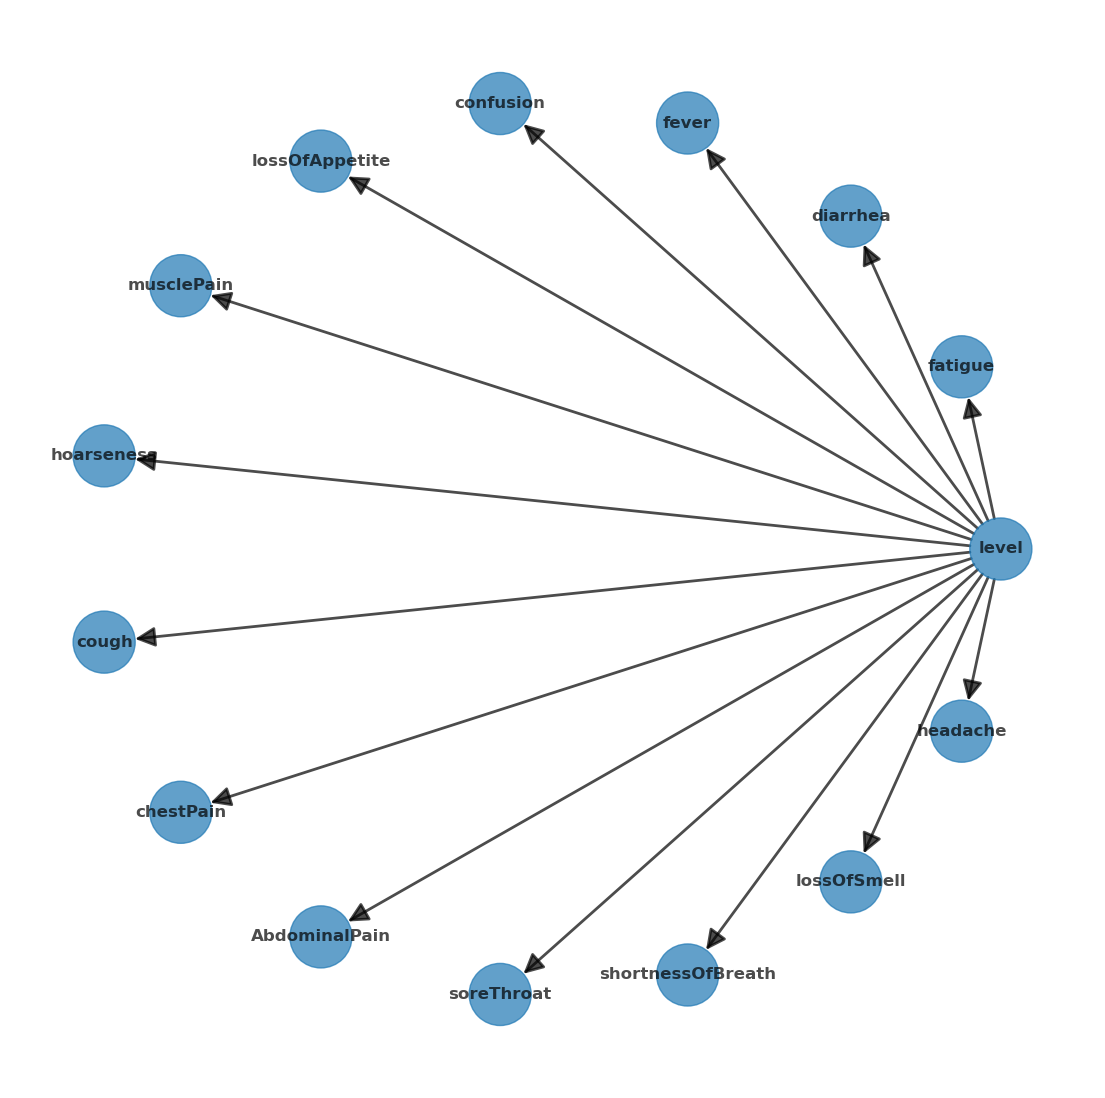

The 'resourceState' node is not present in the original Bayesian network.


In [966]:
plt.figure(3,figsize=(14,14)) 
G = nx.DiGraph()
G.add_edges_from(model.edges)


G.add_nodes_from(model.nodes)
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)

# Set node colors for the main graph
# node_colors = ['b' if node != 'resourceState' else 'r' for node in G.nodes()]

nx.draw_networkx(G,
                pos=pos,
                with_labels=True,
                node_size=[2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000],
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)  # Draw the original graph

tt_g = G.subgraph(nodes=['resourceState'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color='#063970')

plt.show()

if 'resourceState' in model.nodes:
    print("The 'resourceState' node is present in the original Bayesian network.")
else:
    print("The 'resourceState' node is not present in the original Bayesian network.")

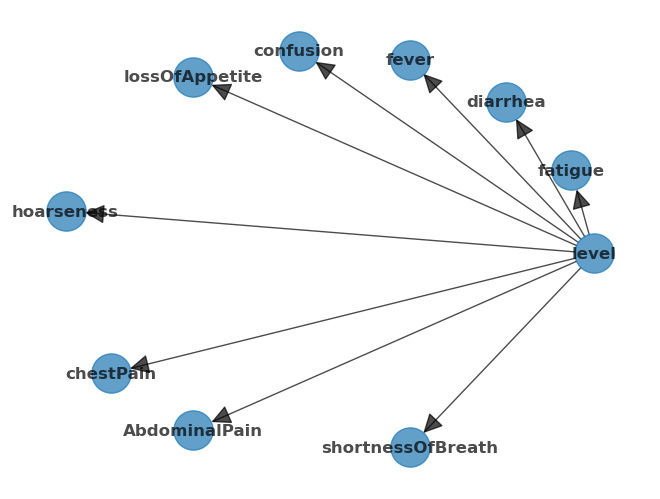

In [967]:
sub_g = G.subgraph(nodes=[ #'headache', 'lossOfSmell', 'musclePain', 'cough', 'soreThroat',
               'chestPain', 'fever', 'hoarseness', 'lossOfAppetite', 'diarrhea', 
               'fatigue', 'confusion', 'shortnessOfBreath', 'AbdominalPain', 'level'])
nx.draw(sub_g, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

## Scoring the model


In [968]:
accuracy_dict = {}

for column in testing_data:
    predict_data = testing_data.copy()
    predict_data.drop(column, axis=1, inplace=True)
    y_pred = model.predict(predict_data)

    accuracy = accuracy_score(testing_data[column], y_pred)

    print(f'{column} Accuracy score: {accuracy}')

    accuracy_dict[column] = accuracy

  0%|          | 0/7700 [00:00<?, ?it/s]

headache Accuracy score: 0.71235


  0%|          | 0/7665 [00:00<?, ?it/s]

lossOfSmell Accuracy score: 0.7115


  0%|          | 0/7665 [00:00<?, ?it/s]

musclePain Accuracy score: 0.711975


  0%|          | 0/7700 [00:00<?, ?it/s]

cough Accuracy score: 0.712625


  0%|          | 0/7724 [00:00<?, ?it/s]

soreThroat Accuracy score: 0.71275


  0%|          | 0/7639 [00:00<?, ?it/s]

chestPain Accuracy score: 0.711975


  0%|          | 0/7691 [00:00<?, ?it/s]

fever Accuracy score: 0.709525


  0%|          | 0/7693 [00:00<?, ?it/s]

hoarseness Accuracy score: 0.712425


  0%|          | 0/7678 [00:00<?, ?it/s]

lossOfAppetite Accuracy score: 0.7138


  0%|          | 0/7714 [00:00<?, ?it/s]

diarrhea Accuracy score: 0.7138


  0%|          | 0/7702 [00:00<?, ?it/s]

fatigue Accuracy score: 0.713825


  0%|          | 0/7663 [00:00<?, ?it/s]

confusion Accuracy score: 0.713125


  0%|          | 0/7670 [00:00<?, ?it/s]

shortnessOfBreath Accuracy score: 0.712925


  0%|          | 0/7703 [00:00<?, ?it/s]

AbdominalPain Accuracy score: 0.716525


  0%|          | 0/12300 [00:00<?, ?it/s]

level Accuracy score: 0.999875


In [969]:
sum = 0
for v in accuracy_dict.values():
    sum += v

accuracy_dict['Average'] = sum / len(accuracy_dict.keys())

accuracy_dict

{'headache': 0.71235,
 'lossOfSmell': 0.7115,
 'musclePain': 0.711975,
 'cough': 0.712625,
 'soreThroat': 0.71275,
 'chestPain': 0.711975,
 'fever': 0.709525,
 'hoarseness': 0.712425,
 'lossOfAppetite': 0.7138,
 'diarrhea': 0.7138,
 'fatigue': 0.713825,
 'confusion': 0.713125,
 'shortnessOfBreath': 0.712925,
 'AbdominalPain': 0.716525,
 'level': 0.999875,
 'Average': 0.7319333333333334}

#### Get structure correlation scores

In [970]:
f1 = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=testing_data)
ss = structure_score(model=model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Structure score: {ss}')

print(model.name)

C:\Users\abidh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Accuracy score: 0.9047619047619048
Precision score: 0.0
Recall score: 0.0
Log-likilihood score: -280735.9788581257
Structure score: -281322.0946482938



#### Conditional Probability Table (CPT)¶

In [971]:
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd * 100, '\n')

Check model: True

CPT of headache:
+---------------+-------------------+-----+----------------------+----------------------+
| level         | level(1.0)        | ... | level(6.0)           | level(7.0)           |
+---------------+-------------------+-----+----------------------+----------------------+
| headache(1.0) | 49.90413870386137 | ... | 0.003116507517016131 | 0.003129067788124562 |
+---------------+-------------------+-----+----------------------+----------------------+
| headache(2.1) | 50.09586129613864 | ... | 99.99688349248298    | 99.99687093221186    |
+---------------+-------------------+-----+----------------------+----------------------+ 

CPT of lossOfSmell:
+------------------+--------------------+-----+----------------------+----------------------+
| level            | level(1.0)         | ... | level(6.0)           | level(7.0)           |
+------------------+--------------------+-----+----------------------+----------------------+
| lossOfSmell(1.0) | 49.960012

### Explanaiton

* In this COVID-19 dataset, a descriptive analysis of the Bayesian network was conducted with 200,000 observations and 15 features, where all the columns have binary values except the 'level' column, which is the severity level and the target variable. The 'level' column has 7 unique values ranging from 0 to 6, with a mean of 1.500665, a standard deviation of 2.061774, and a range of values from 0 to 6.


  The model analysis shows that the Bayesian network accurately predicts the level of severity of COVID-19 in patients based on their symptoms, as the accuracy score is high when the symptom is removed, and the CPT of the 'level' feature shows the probability distribution of the different levels of severity of COVID-19 given the presence or absence of the various symptoms.
  
  
  However, the goodness of fit structure score and Log-likelihood score are negative, indicating that the model is not fitting the data well. This suggests that further refinement and optimization of the model may be necessary to improve its performance.
  

  Overall, the Bayesian network analysis of this COVID-19 dataset provides valuable insights into the interdependence of the different symptoms and their relationship to the severity of COVID-19, which can help in the early diagnosis and treatment of the disease.
